# i. Business Understanding

## i.i Cardio Catch Diseases Company

* Cadio Catch Diseases is a company that specializes in detecting heart disease in the early stages. Its business model is service type, that is, the company offers an early diagnosis of cardiovascular disease for a certain price.

* Currently, the diagnosis of cardiovascular disease is made manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also the fatigue of the team who take turns to minimize the risks. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de $ 1,000.00.

* Currently, the diagnosis of cardiovascular disease is made manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also the fatigue of the team who take turns to minimize the risks. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de $ 1,000.00.

## i.ii The Challenge

* The objective as a Data Scientist hired by Cardio Catch Diseases is to create a tool that increases the accuracy of the diagnosis and that this accuracy is stable for all diagnoses.

### i.ii.i Business Questions

1. What is the Accuracy and Precision of the tool?

1. How much profit will Cardio Catch Diseases have with the new tool?

1. How Reliable is the result given by the new tool?

# 0.0 Imports and Helper Functions

## 0.1 Imports

In [ ]:
import warnings

import numpy   as np
import pandas  as pd
import seaborn as sns

from scipy      import stats
from joblib     import load, dump
from xgboost    import XGBClassifier

from matplotlib import pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.dummy             import DummyClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.preprocessing     import RobustScaler

from sklearn.metrics           import accuracy_score, make_scorer, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection   import train_test_split, KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

## 0.2 Helper Functions

In [ ]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"))
recall = make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"))
f1 = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"))

In [ ]:
def ml_scores(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return pd.DataFrame({'Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3)}, index=[model_name])

In [ ]:
def ml_cv_results(model_name, model, X, y):

    X_ = X.to_numpy()
    y_ = y.to_numpy()

    rb = RobustScaler()

    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    '''for for cross validation'''
    kf = KFold(n_splits=5, shuffle=True)
    for train, test in kf.split(X_):

        X_train, X_test = X_[train], X_[test]
        y_train, y_test = y_[train], y_[test]

        X_train = rb.fit_transform(X_train)
        X_test = rb.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average="macro"))
        recalls.append(recall_score(y_test, y_pred, average="macro"))
        f1s.append(f1_score(y_test, y_pred, average="macro"))

    accuracy_mean, accuracy_std = np.round(np.mean(accuracies), 3), np.round(np.std(accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)

    return pd.DataFrame({"Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std)},
                       index=[model_name])

In [ ]:
def calcCramerV(x, y):

    if not np.issubdtype(x.dtype, np.number):
        x = pd.Series(x).astype('category').cat.codes
    if not np.issubdtype(y.dtype, np.number):
        y = pd.Series(y).astype('category').cat.codes

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    denominator = min(kcorr - 1, rcorr - 1)
    if denominator == 0:
        return 0.0

    return np.sqrt((chi2corr / n) / denominator)

Based on [The 12 Stages of Life](https://www.institute4learning.com/resources/articles/the-12-stages-of-life/), I'll create a function to identify each stage of the life. It will help in data analysis step.

In [ ]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"

    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"

    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"

    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"

    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"

    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"

    elif age > 35 and age <= 50:
        life_stage = "Midlife"

    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"

    else:
        life_stage = "Late Adulthood"

    return life_stage

Based on [Measuring BMI for adults, children, and teens](https://www.medicalnewstoday.com/articles/323622#Understanding-the-results), I'll calculate the BMI and determine if there's any overwigth or not.

In [ ]:
def calcIBM(weight, height):
    #BMI = kg/m2
    ibm = np.round(weight / (height**2), 1)

    return ibm

def catIBM(ibm):
    if ibm < 18.5:
        status = "Underweight"

    elif ibm >= 18.5 and ibm <= 24.9:
        status = "Healthy"

    elif ibm >= 25.0 and ibm <= 29.9:
        status = "Overweight"

    elif ibm >= 30.0:
        status = "Obese"

    return status

# 1.0 Data Description

In [ ]:
df1 = pd.read_csv("database/cardio.csv", sep=";", low_memory=False)

In [ ]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df1.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


## 1.1 Rename Columns

In [ ]:
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "disease"}

df1.rename(columns=new_columns, inplace=True)

In [ ]:
df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.2 Data Dimensions

In [ ]:
print('Number of Rows: {}'.format( df1.shape[0]))
print('Number of Cols: {}'.format( df1.shape[1]))

Number of Rows: 70000
Number of Cols: 13


## 1.3 Data Types

I'll change the attributes from numbers to string, because it'll help in data analysis step.

In [ ]:
df1["cholesterol"] = df1["cholesterol"].map({1: "normal", 2: "above normal", 3: "well above normal"})
df1["glucose"] = df1["glucose"].map({1: "normal", 2: "above normal", 3: "well above normal"})
df1["smoking"] = df1["smoking"].map({0: "No", 1: "Yes"})
df1["alcohol"] = df1["alcohol"].map({0: "No", 1: "Yes"})
df1["physical_activity"] = df1["physical_activity"].map({0: "No", 1: "Yes"})
df1["disease"] = df1["disease"].map({0: "No", 1: "Yes"})
df1["gender"] = df1["gender"].map({1: "women", 2: "men"})

In [ ]:
df1.dtypes

,0
id,int64
age,int64
gender,object
height,int64
weight,float64
systolic_blood_pressure,int64
diastolic_blood_pressure,int64
cholesterol,object
glucose,object
smoking,object


## 1.4 Check Na

In [ ]:
df1.isna().sum()

,0
id,0
age,0
gender,0
height,0
weight,0
systolic_blood_pressure,0
diastolic_blood_pressure,0
cholesterol,0
glucose,0
smoking,0


## 1.5 Descriptive Statistics

In [ ]:
num_attributes = df1[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure"]]
cat_attributes = df1[["cholesterol", "gender", "glucose", "smoking", "alcohol", "physical_activity", "disease"]]

### 1.5.1 Numerical Attribures

In [ ]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0,195.0,0.049952,-0.642187,7.943653
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0,190.0,0.193998,1.012070,2.586825
systolic_blood_pressure,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0,16170.0,1.195580,85.296214,7580.074738
diastolic_blood_pressure,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0,11070.0,1.950447,32.114083,1425.914585



### 1.5.2 Categorical Attributes

In [ ]:
cat_attributes.describe()

,cholesterol,gender,glucose,smoking,alcohol,physical_activity,disease
count,70000,70000,70000,70000,70000,70000,70000
unique,3,2,3,2,2,2,2
top,normal,women,normal,No,No,Yes,No
freq,52385,45530,59479,63831,66236,56261,35021


# 2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

## 2.1 Mind Map

In [ ]:
# Image("../images/mindmap.png")

## 2.2 Creating Hypothesis

1. The older a person is, the more likely they are to be sick.
1. Who smokes has more the chance to be sick.
1. Who doesn't make physical activity may be sick.
1. The more obese a person is, the more chance of being sick.
1. High cholesterol means that the person may have heart problems.

## 2.3 Feature Engineering

In [ ]:
df2["age_year"] = df2["age"].apply(lambda i: int(np.round(i / 365)))
df2["life_stage"] = df2["age_year"].apply(getLifeStage)

In [ ]:
df2["IBM"] = df2[["height", "weight"]].apply(lambda i: calcIBM(i["weight"], i["height"]/100), axis=1)
df2["weight_status"] = df2["IBM"].apply(catIBM)

# 3.0 Filtering Variables

In [ ]:
df3 = df2.copy()

## 3.1 Filtering Lines

Seeing systolic and dystolic blood pressure there's some outliers. I'll use [Understanding Blood Pressure Readings](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings) as a reference to select some lines.

In [ ]:
df3 = df3[(df3["systolic_blood_pressure"] < 300) & (df3["systolic_blood_pressure"] > 0)]
df3 = df3[(df3["diastolic_blood_pressure"] < 300) & (df3["diastolic_blood_pressure"] > 0)]

In [ ]:
df3 = df3.drop_duplicates()

## 3.2 Filtering Columns

I will drop the column "age" because I've created the column "age_year" as a alternative.

In [ ]:
df3 = df3.drop(columns=["age"], axis=1)

# 4.0 Exploratory Data Analysis

In [ ]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

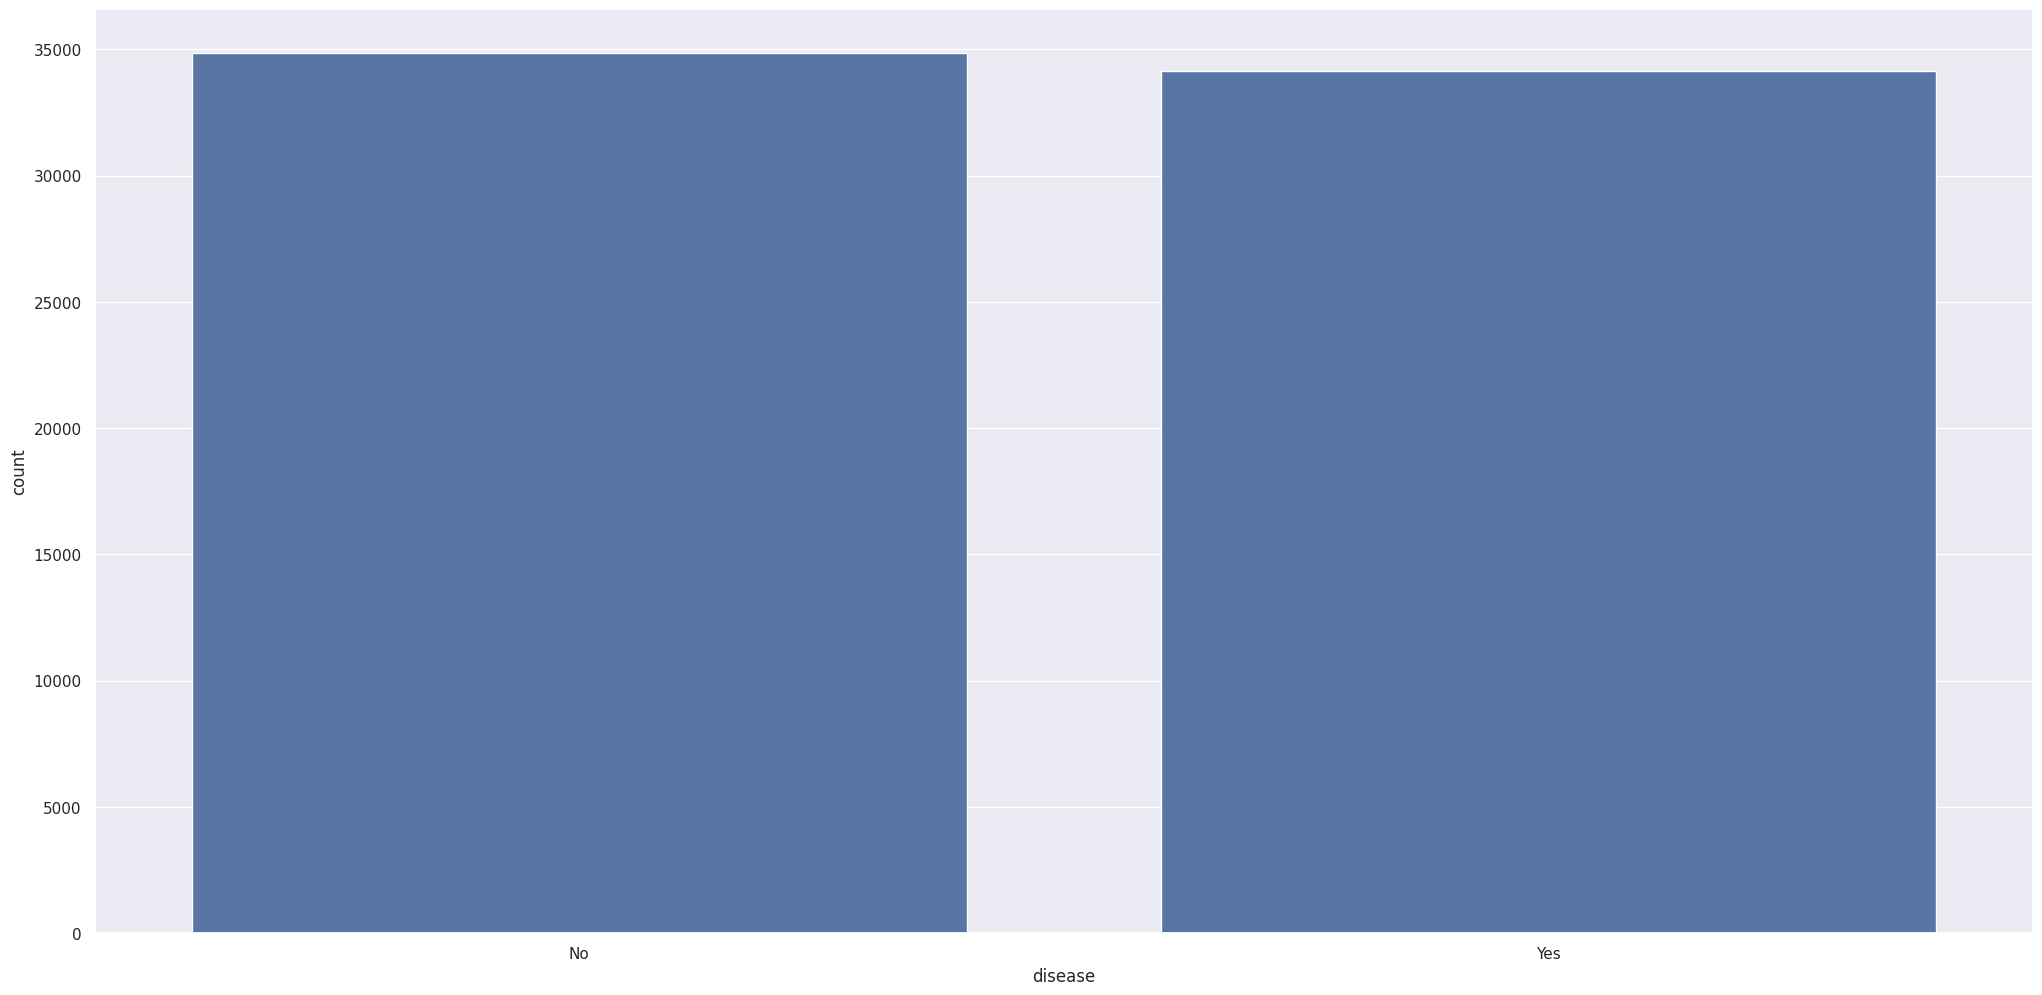

In [ ]:
sns.countplot(x="disease", data=df4);

### 4.1.2 Numerical Variable

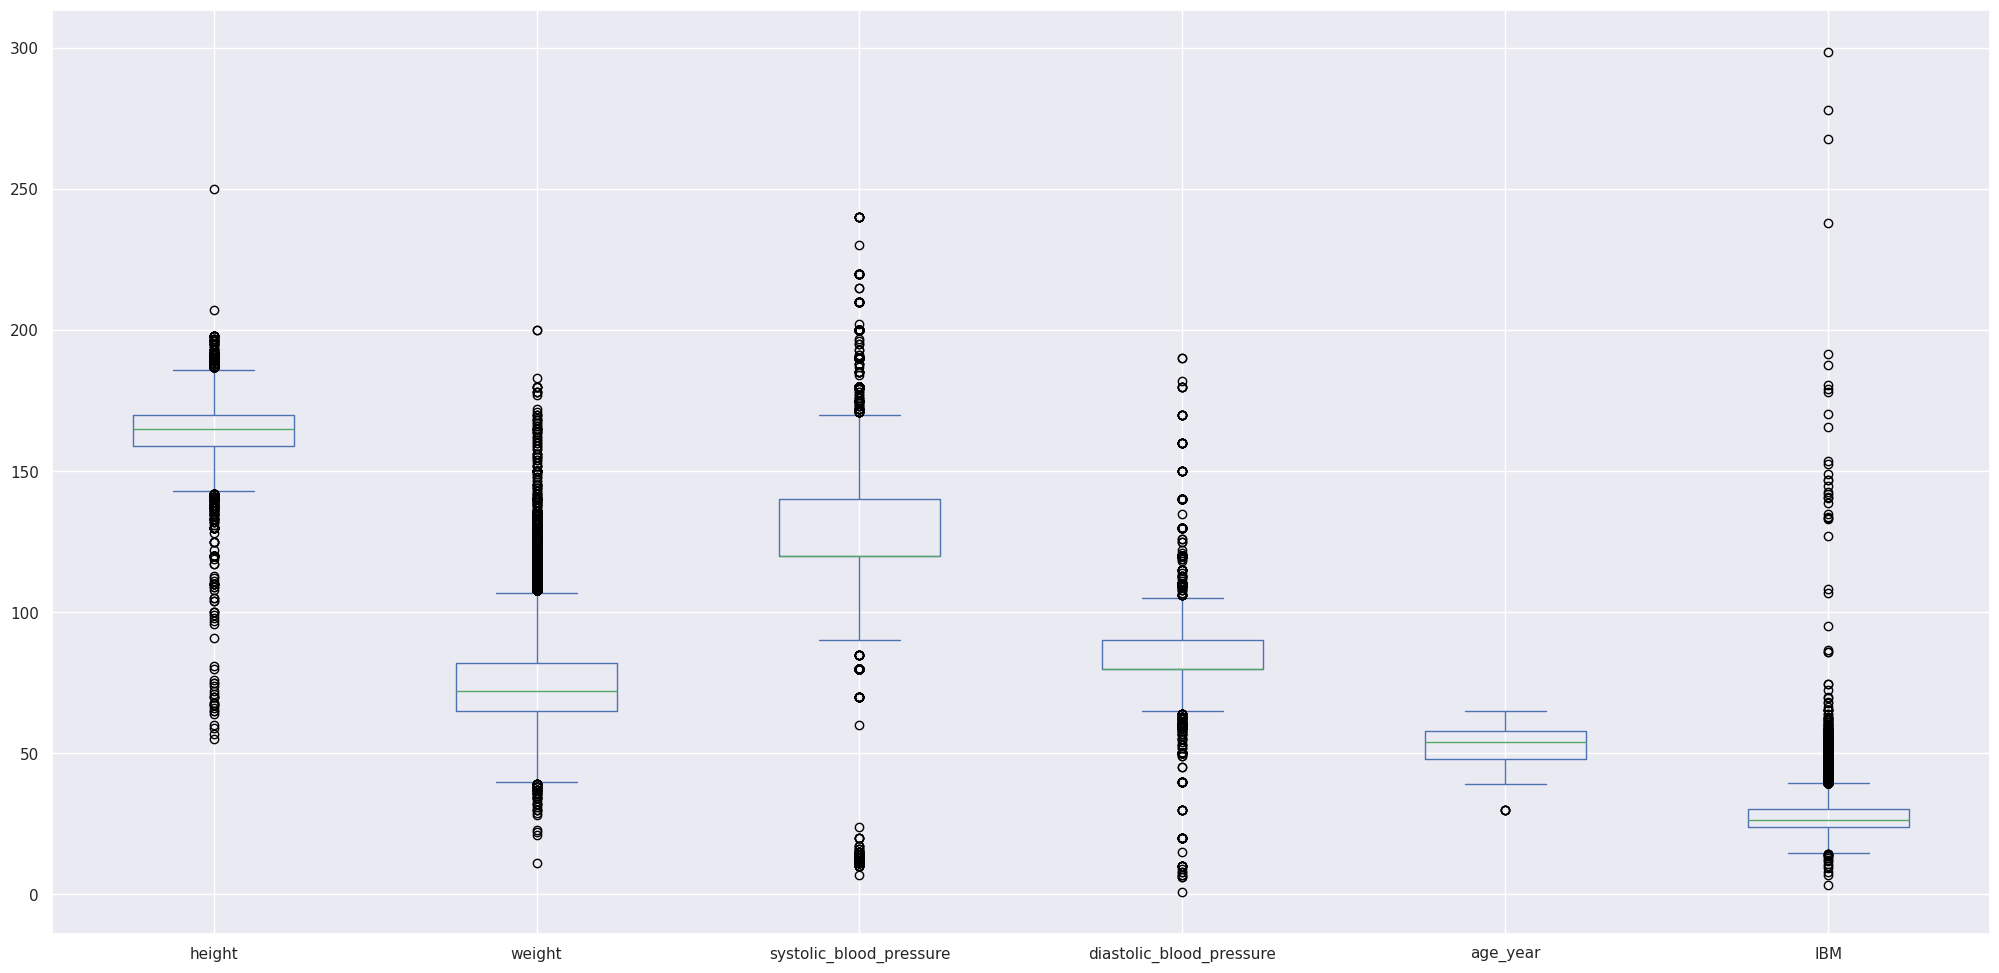

In [ ]:

ax1 = df4.select_dtypes(exclude=["object"]).drop(columns=["id"], axis=1)
ax1.plot.box();

### 4.1.3 Categorical Variables

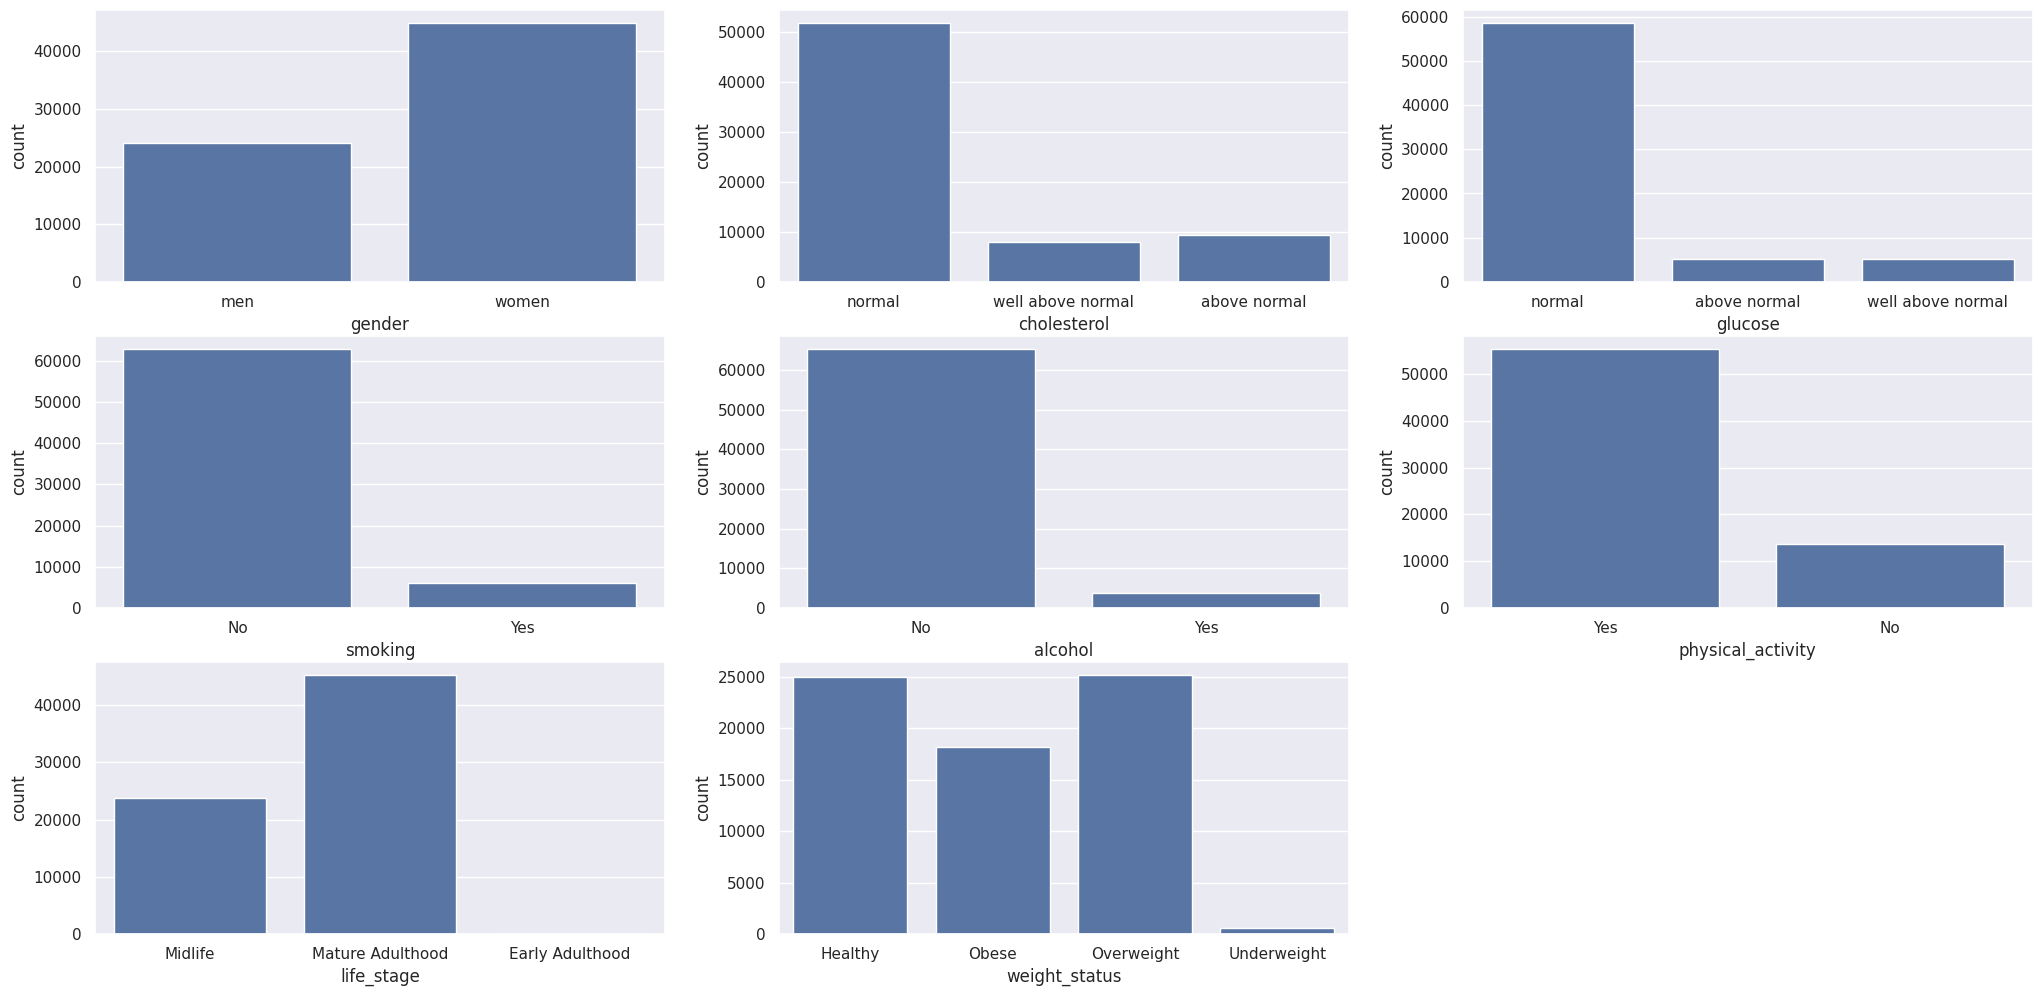

In [ ]:
aux1 = df4.select_dtypes(include="object")

plt.subplot(3, 3, 1)
sns.countplot(x="gender", data=aux1);

plt.subplot(3, 3, 2)
sns.countplot(x="cholesterol", data=aux1);

plt.subplot(3, 3, 3)
sns.countplot(x="glucose", data=aux1);

plt.subplot(3, 3, 4)
sns.countplot(x="smoking", data=aux1);

plt.subplot(3, 3, 5)
sns.countplot(x="alcohol", data=aux1);

plt.subplot(3, 3, 6)
sns.countplot(x="physical_activity", data=aux1);

plt.subplot(3, 3, 7)
sns.countplot(x="life_stage", data=aux1);

plt.subplot(3, 3, 8)
sns.countplot(x="weight_status", data=aux1);

## 4.2 Bivariate Analysis

### H1 The older a person is, the more likely they are to be sick.
**TRUE** The older the pearson is the probability to be sick is higher.

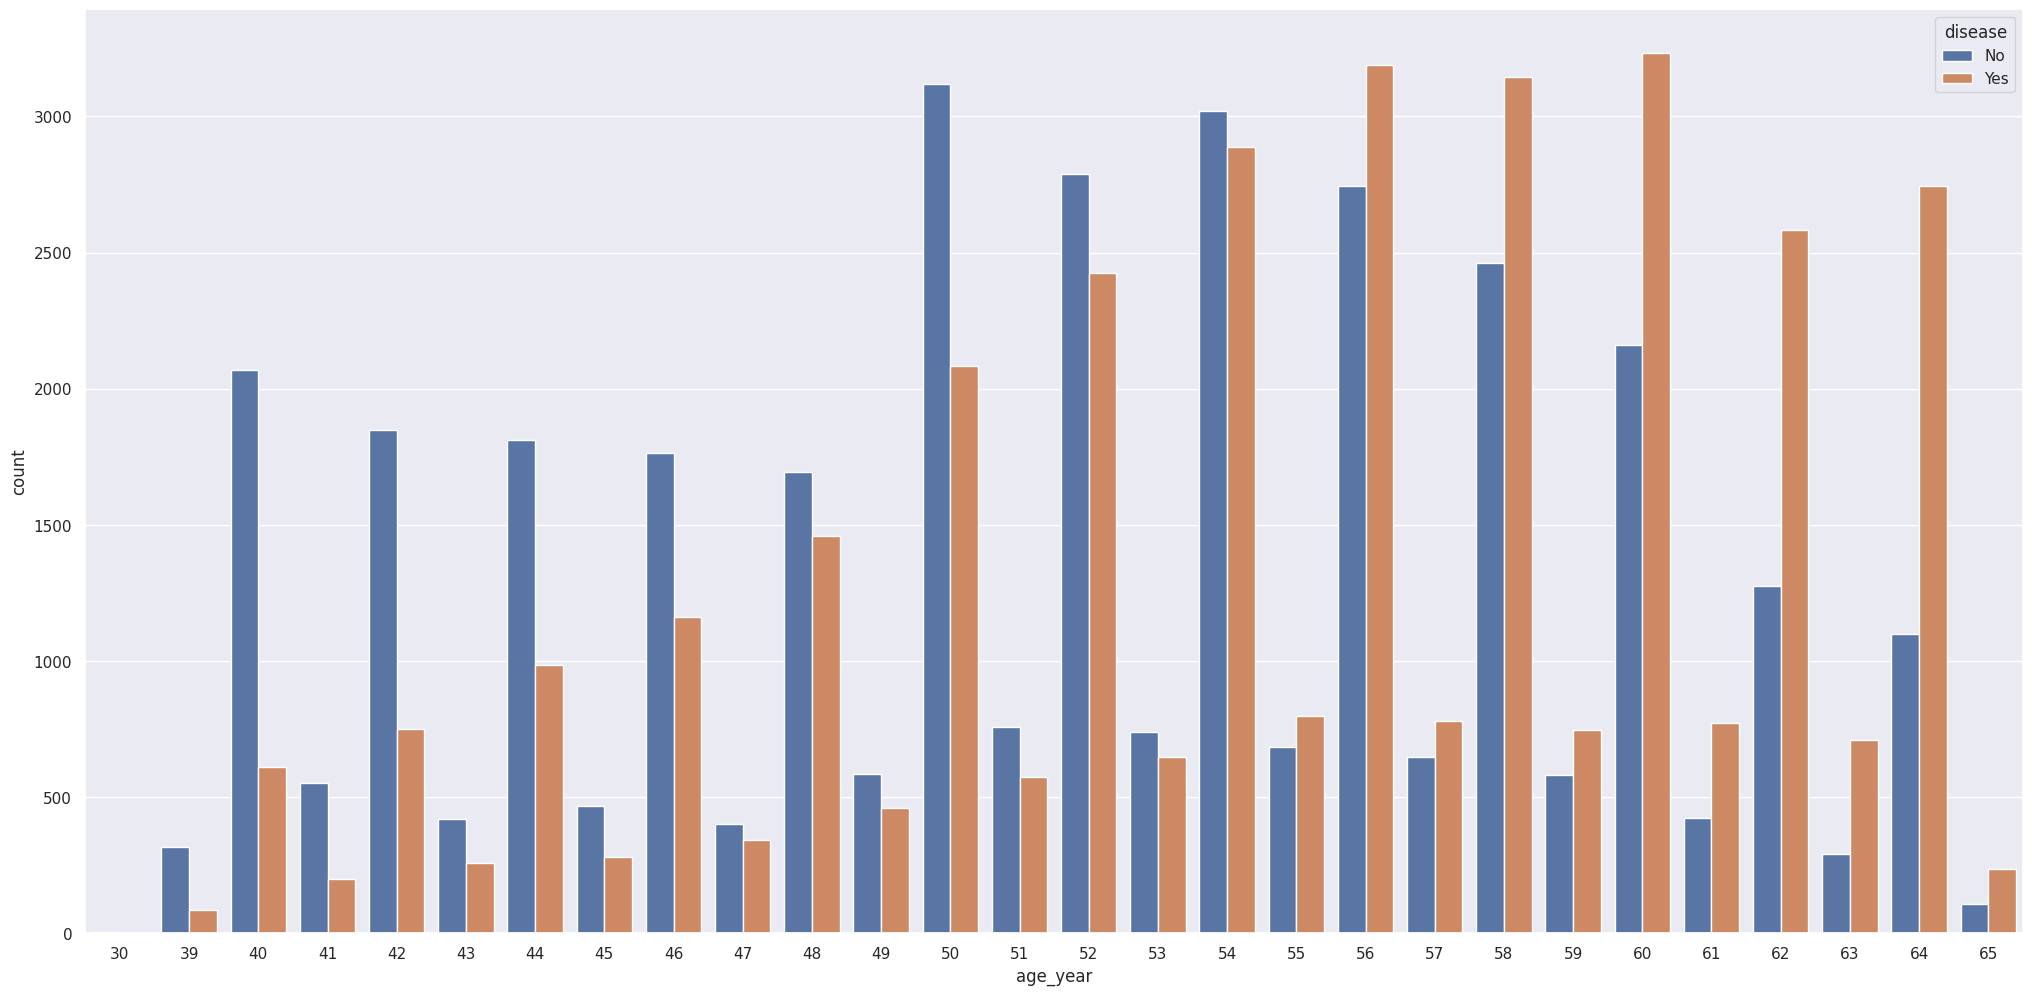

In [ ]:
sns.countplot(x="age_year", data=df4, hue="disease");

### H2 Who smokes has more the chance to be sick.

**FALSE** If they smoke it doesn't mean they're dicease.

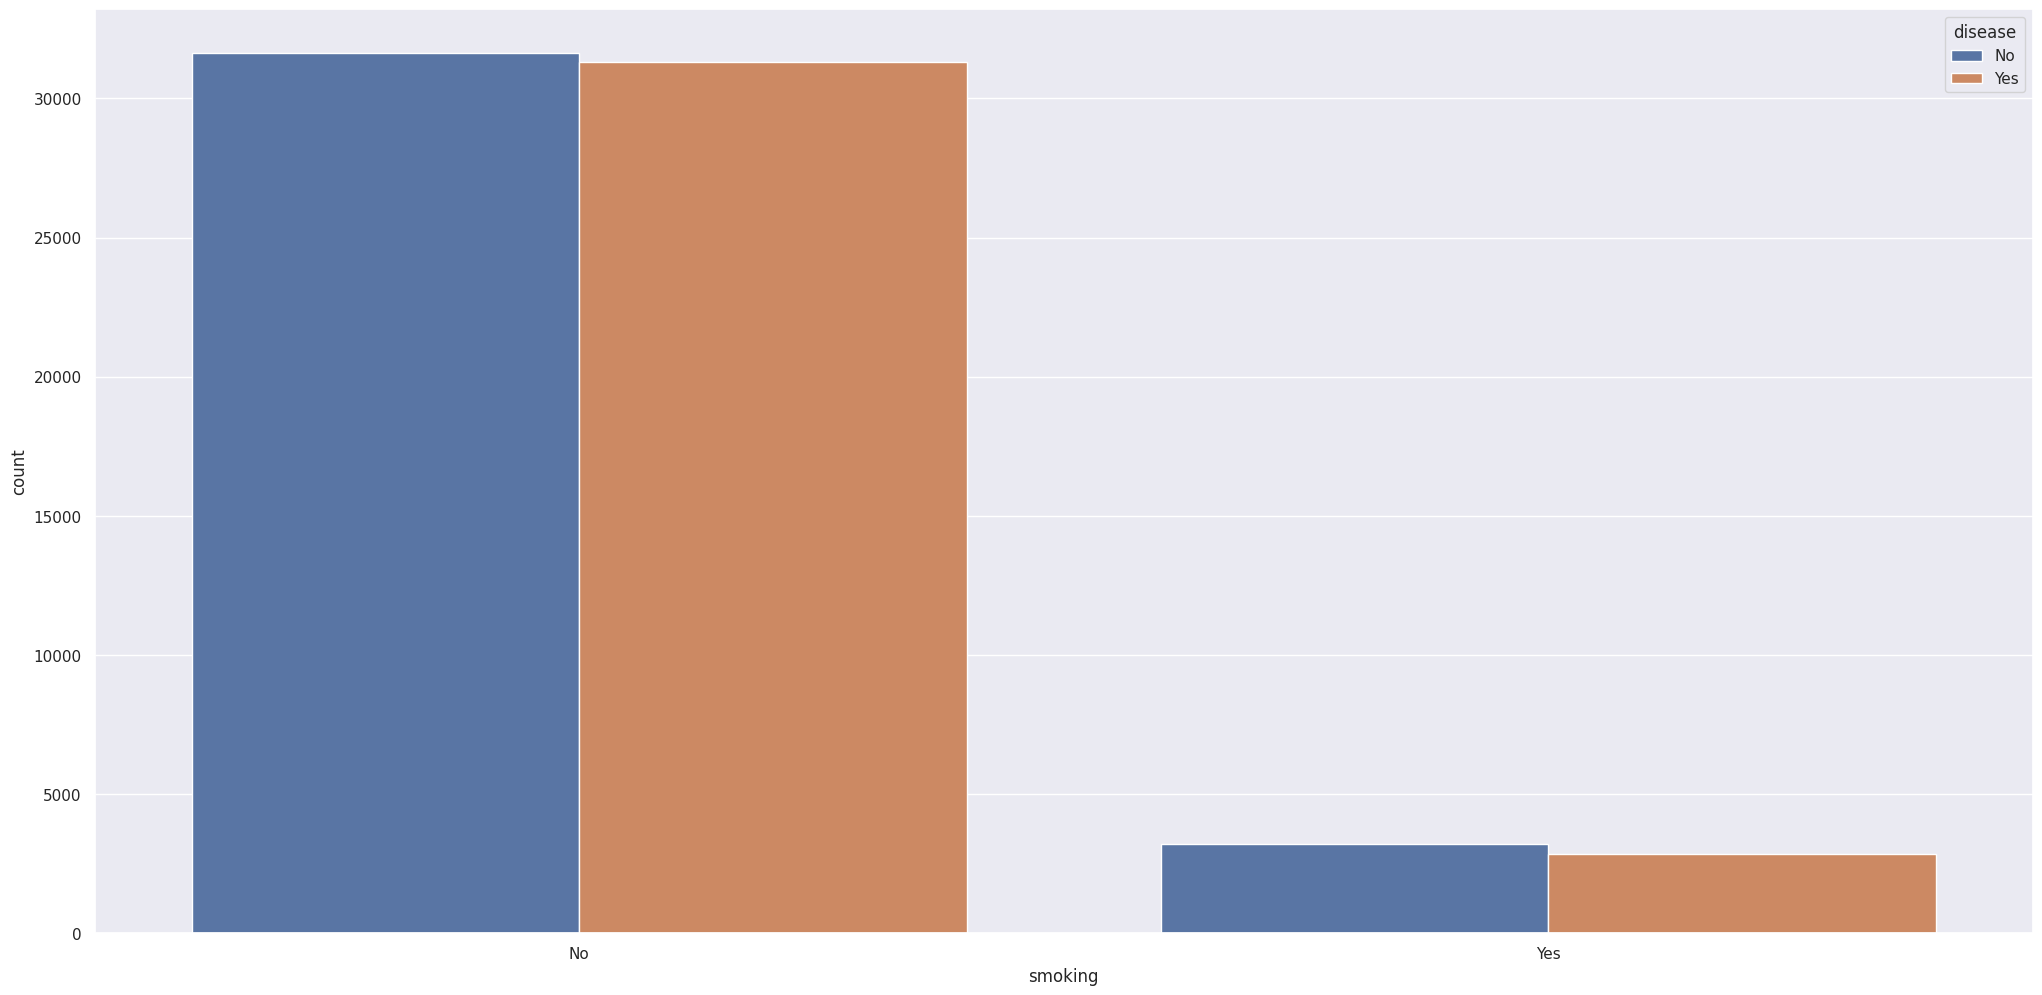

In [ ]:
sns.countplot(x="smoking", data=df4, hue="disease");

### H3 Who doesn't make physical activity may be sick.

**TRUE** There's more sick peaple which doesn't make physical activity.

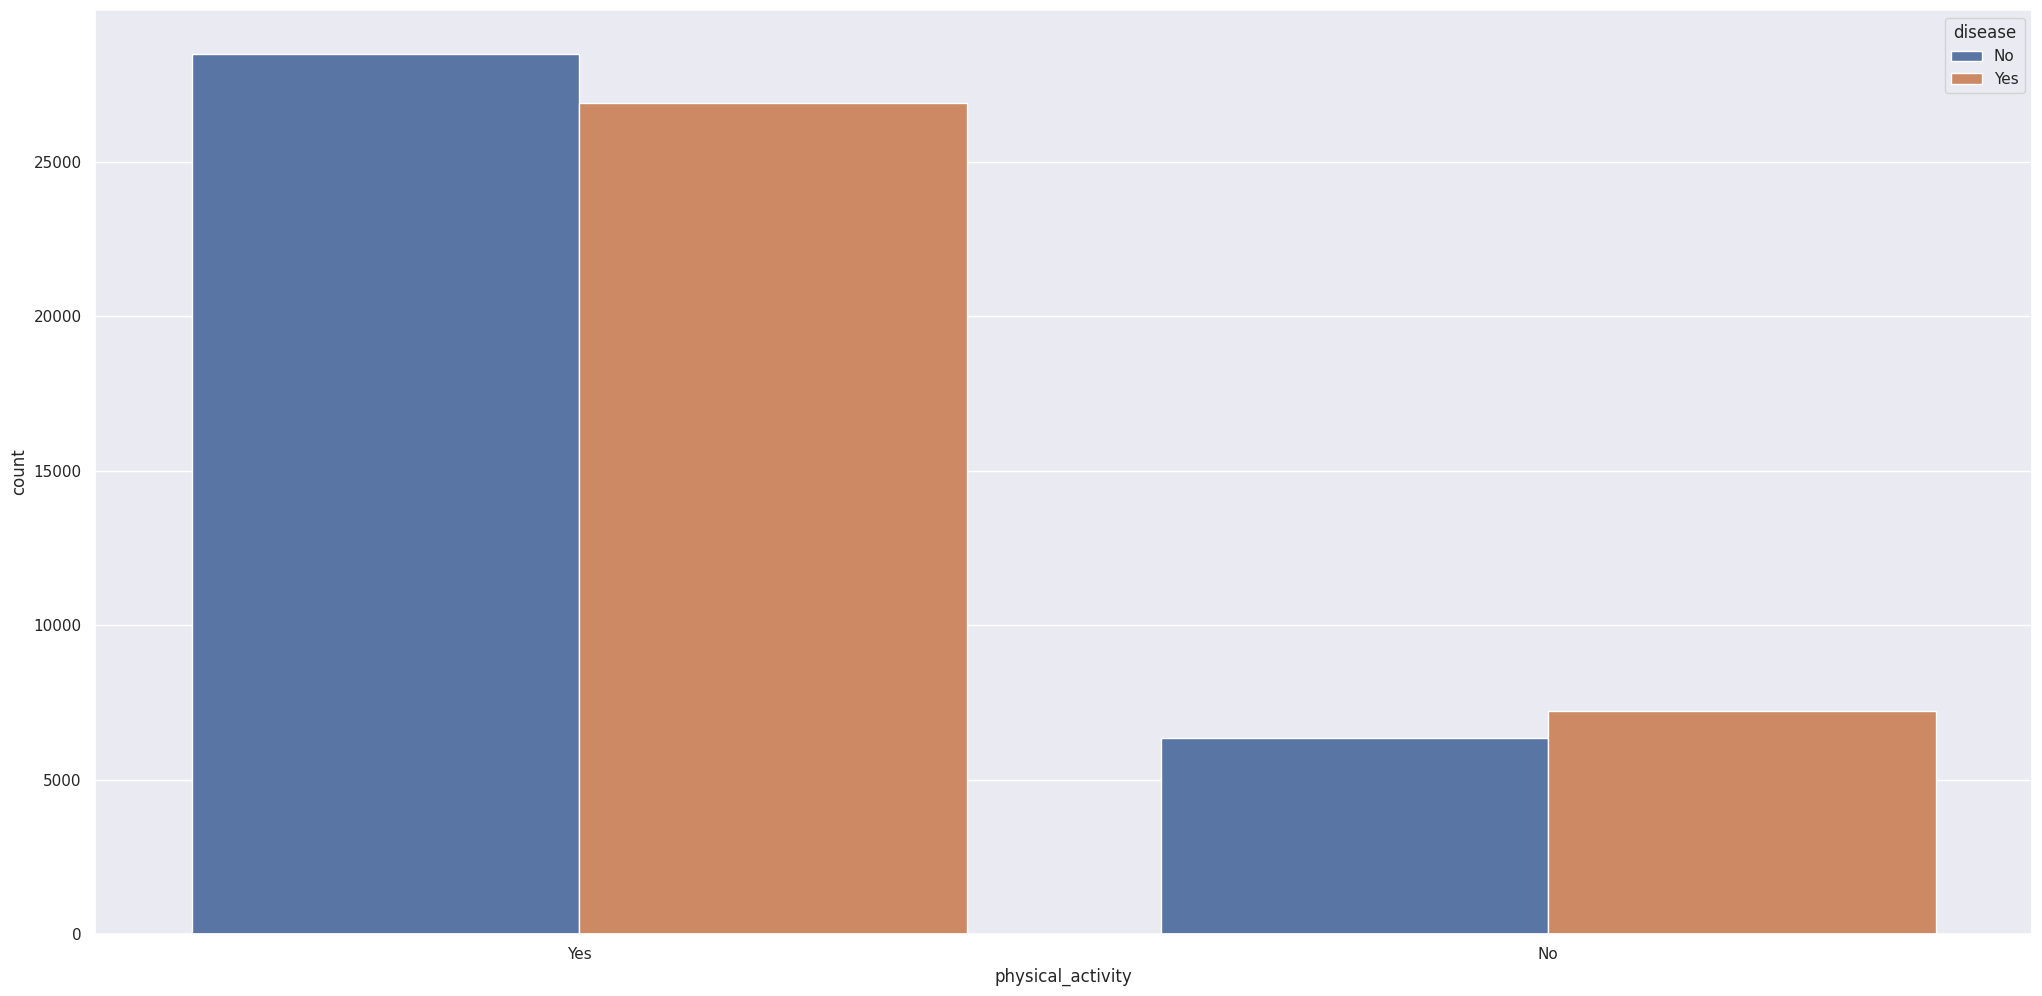

In [ ]:
sns.countplot(x="physical_activity", data=df4, hue="disease");

### H4 The more obese a person is, the more chance of being sick.

**TRUE** There's more sick peaple whom weight status is obese and overweight

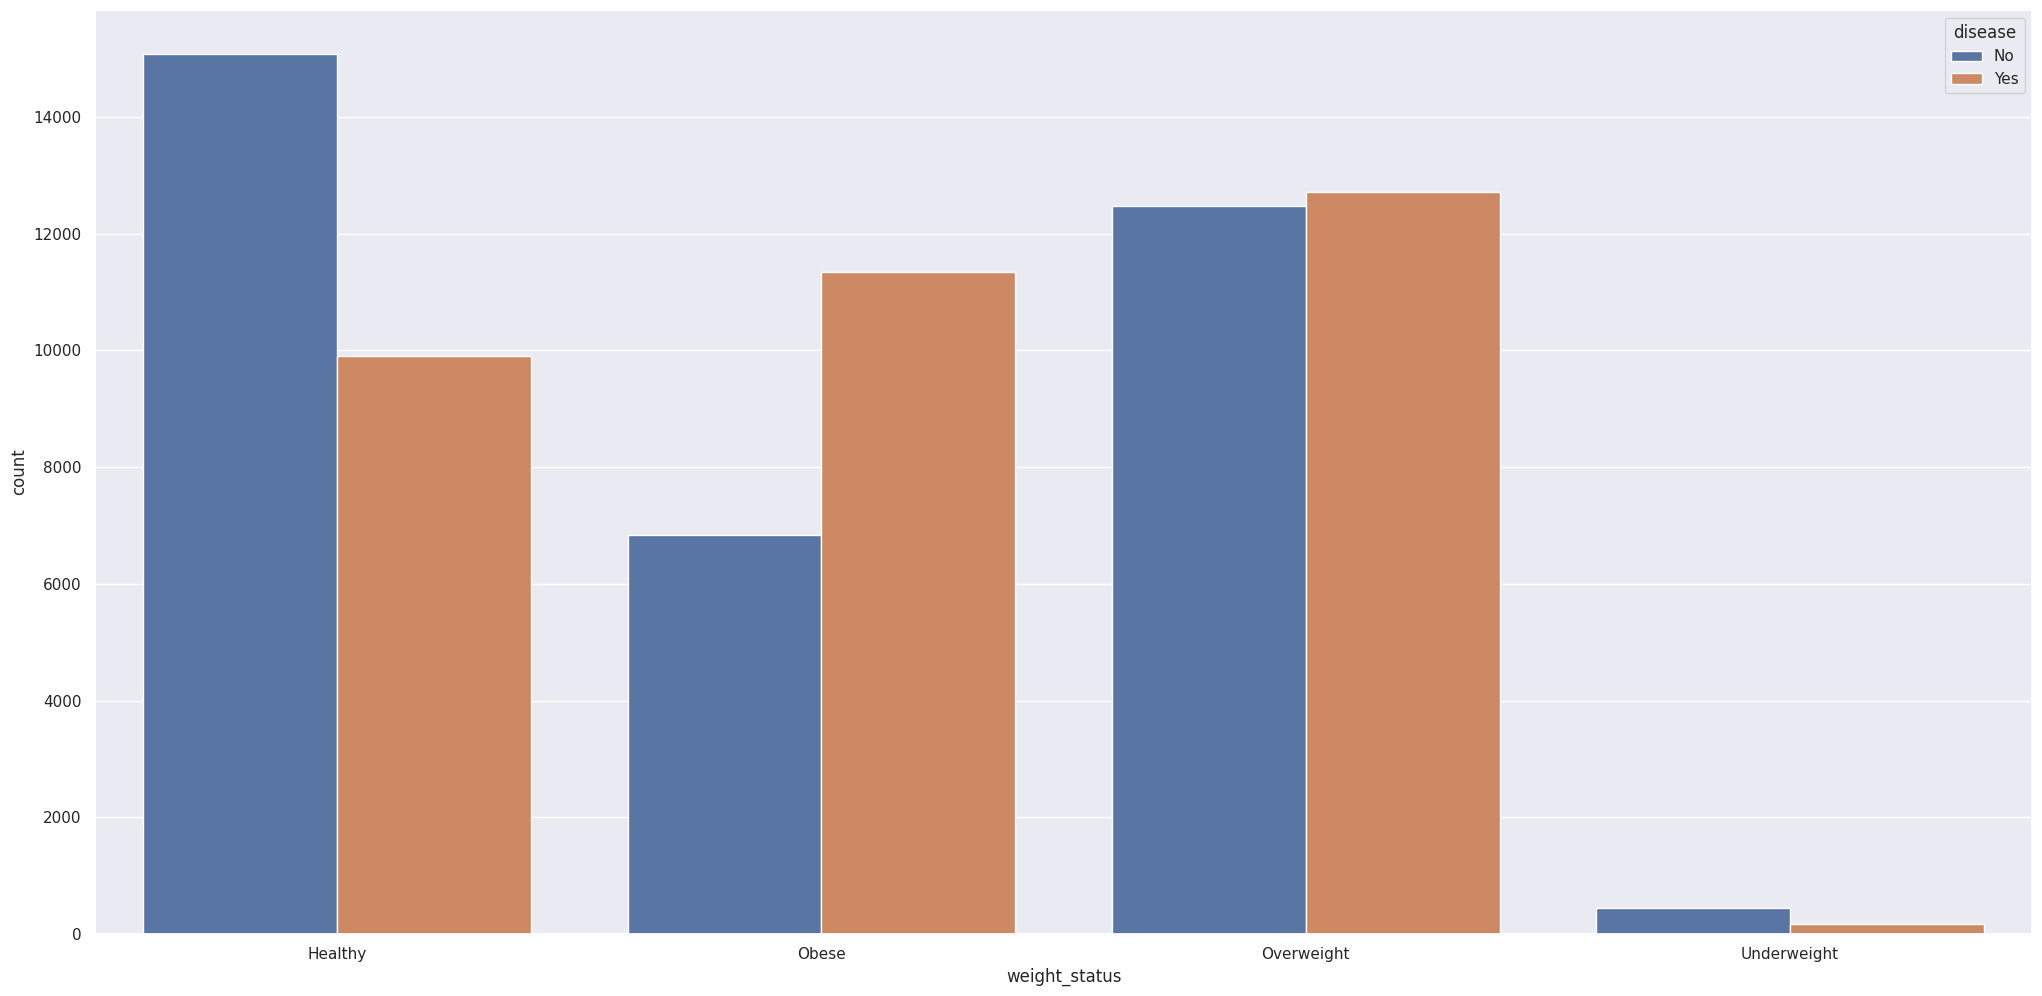

In [ ]:
sns.countplot(x="weight_status", data=df4, hue="disease");

### H5 High cholesterol means that the person may have heart problems.

**TRUE** There's more sick peaple who has the cholesterol above and well above normal.

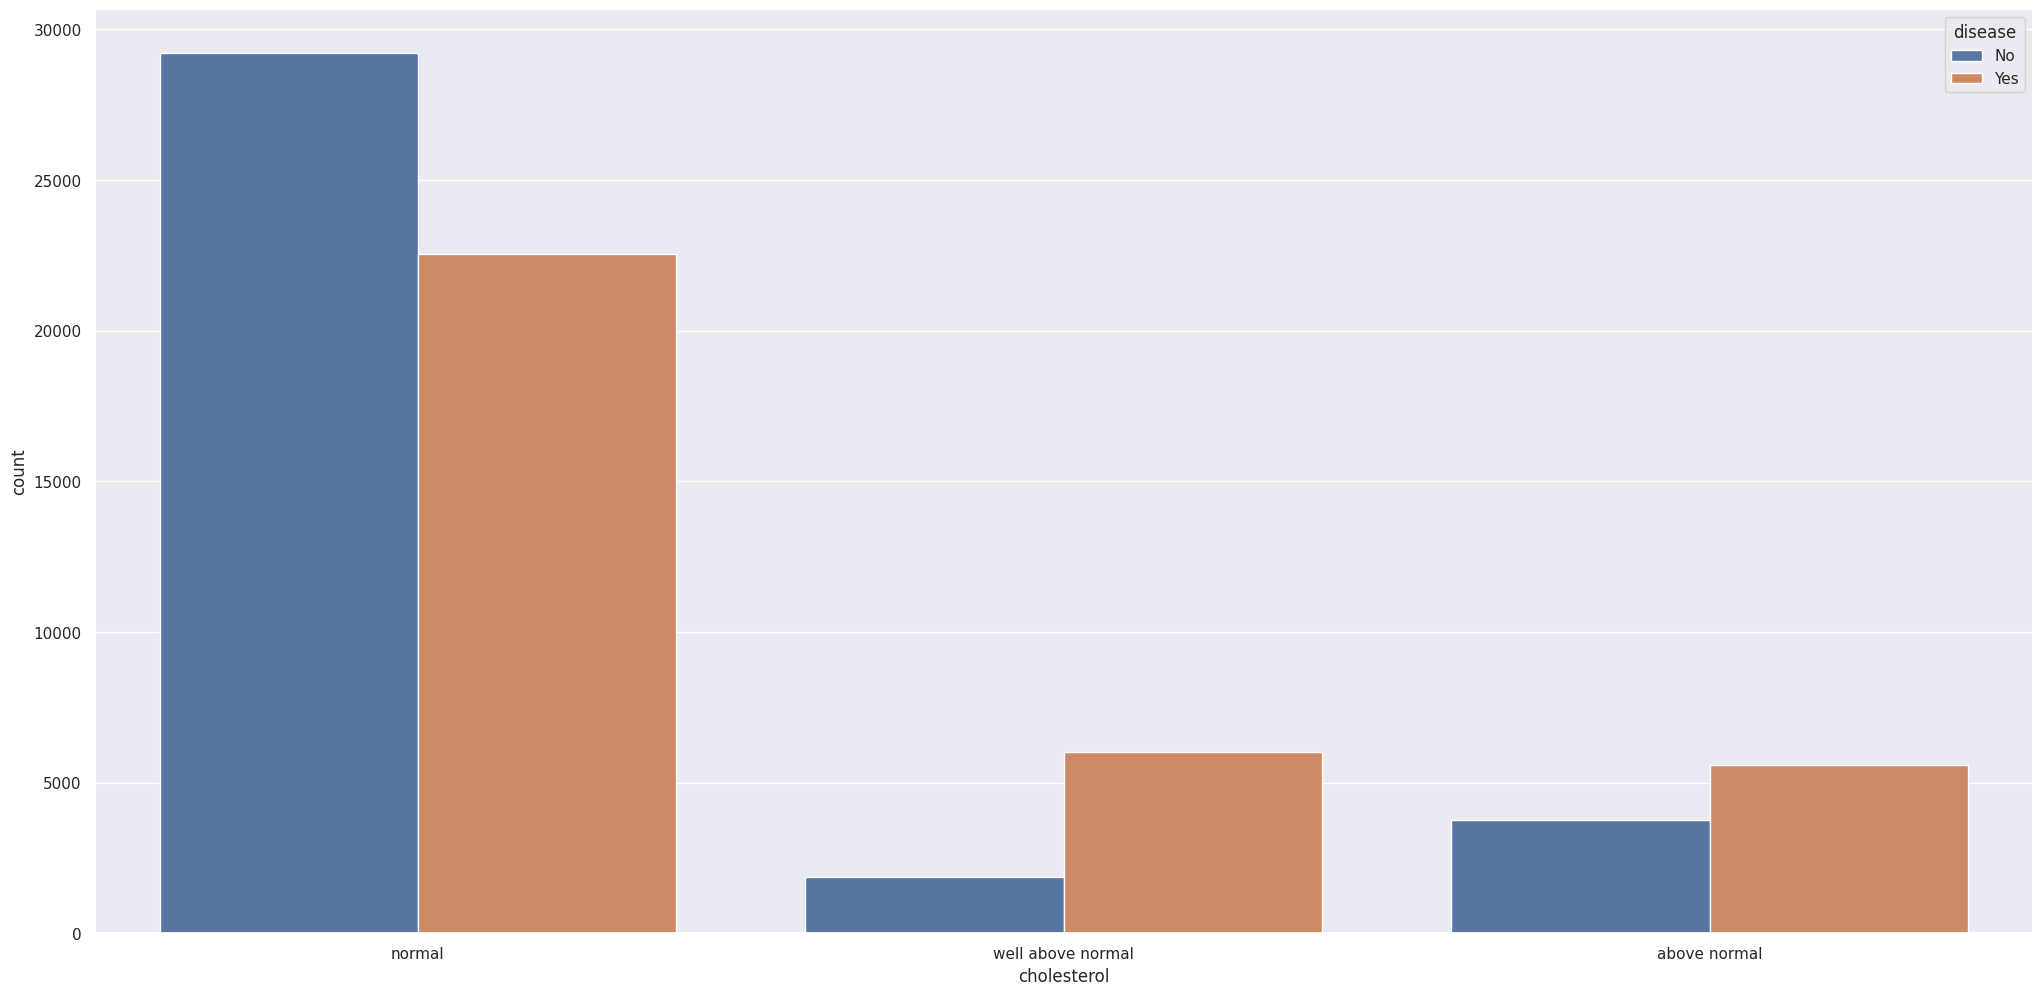

In [ ]:
sns.countplot(x="cholesterol", data=df4, hue="disease");

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [ ]:
aux1 = df4.select_dtypes(exclude="object").drop("id", axis=1)
corr = aux1.corr()

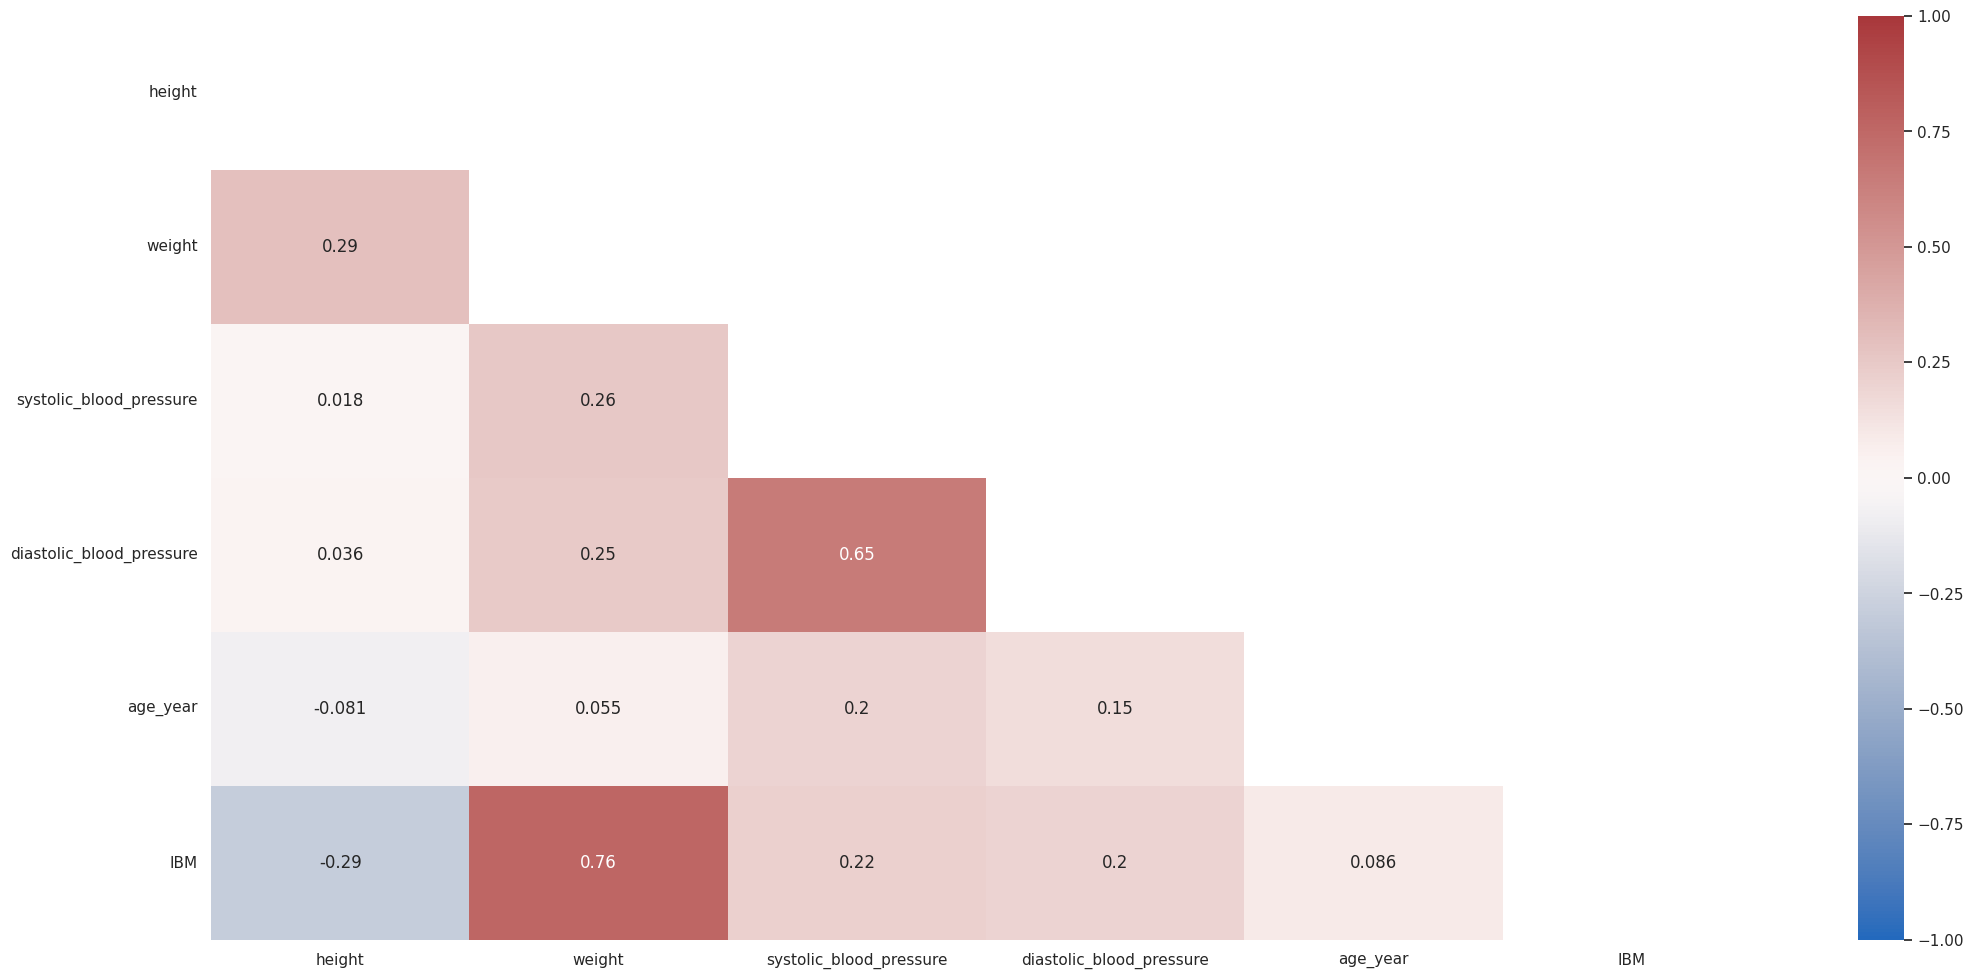

In [ ]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, vmax=1, vmin=-1, mask=mask, center=0, cmap="vlag");

### 4.3.2 Categorical Atributes

In [ ]:
aux1 = df4.select_dtypes(include="object")

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy()

## 5.1 Enconding

In [ ]:
df5["cholesterol"] = df5["cholesterol"].map({"normal": 0, "above normal": 1, "well above normal": 2})
df5["glucose"] = df5["glucose"].map({"normal": 0, "above normal": 1, "well above normal": 2})
df5["weight_status"] = df5["weight_status"].map({"Underweight": 0, "Healthy": 1, "Obese": 2, "Overweight": 3})

## 5.2 OneHot Enconding

This step will increase the data dimension, however later I'll apply a algorithm to select the best columns for model training and prediction. It'll deacrease the data dimension and improve the model score.

In [ ]:
df5["disease"] = df5["disease"].map({"Yes": 1, "No": 0})

In [ ]:
ohe_columns = ["gender", "smoking", "alcohol", "physical_activity", "life_stage"]
df5 = pd.get_dummies(df5, columns=ohe_columns, drop_first=True)

## 5.3 Spliting into Train, Valid and Test

In [ ]:
X = df5.drop(columns=["id", "disease"], axis=1)
y = df5["disease"]

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

## 5.4 Rescaling

Rescaling it's important to make the prediction faster and each feature contributes equally for model learning. However, there are a lot of outliers, so in this PRISM step I'll use robust scaler. For another cicle step I can try to treat the outliers.

In [ ]:
rbs = RobustScaler()
rescale_columns = ["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_year", "IBM"]

X_train[rescale_columns] = rbs.fit_transform(X_train[rescale_columns])
X_valid[rescale_columns] = rbs.transform(X_valid[rescale_columns])

In [ ]:
X_params = X_temp.copy()

X_params[rescale_columns] = rbs.fit_transform(X_params[rescale_columns])
X_test[rescale_columns] = rbs.transform(X_test[rescale_columns])

# 6.0 Feature Selection

## 6.1 Random Forest as Feature Selector

In [ ]:
# rf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)

# sfm = SelectFromModel(estimator=rf)
# sfm.fit(X_params, y_temp)

### 6.2.1 Best Selected Columns

In [ ]:
# best_columns = sfm.get_support()
# best_columns_rf = X_params.loc[:, best_columns].columns.to_list()

In [ ]:
best_columns_rf = ['height', 'weight', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'age_year', 'IBM']

# 7.0 Machine Learning Modeling

In [ ]:
X_train_cs = X_train[best_columns_rf]
X_valid_cs = X_valid[best_columns_rf]

X_params_cs = X_params[best_columns_rf]
X_temp_cs = X_temp[best_columns_rf]
X_test_cs = X_test[best_columns_rf]

## 7.1 Baseline Model

In [ ]:
dummy = DummyClassifier(strategy="prior")
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)
y_prob = dummy.predict_proba(X_valid_cs)[:, 1]

### 7.1.1 Results

In [ ]:
dummy_resul = ml_scores("Dummy", y_valid, y_pred)
dummy_resul

,Accuracy,Precision,Recall,F1
Dummy,0.505,0.0,0.0,0.0


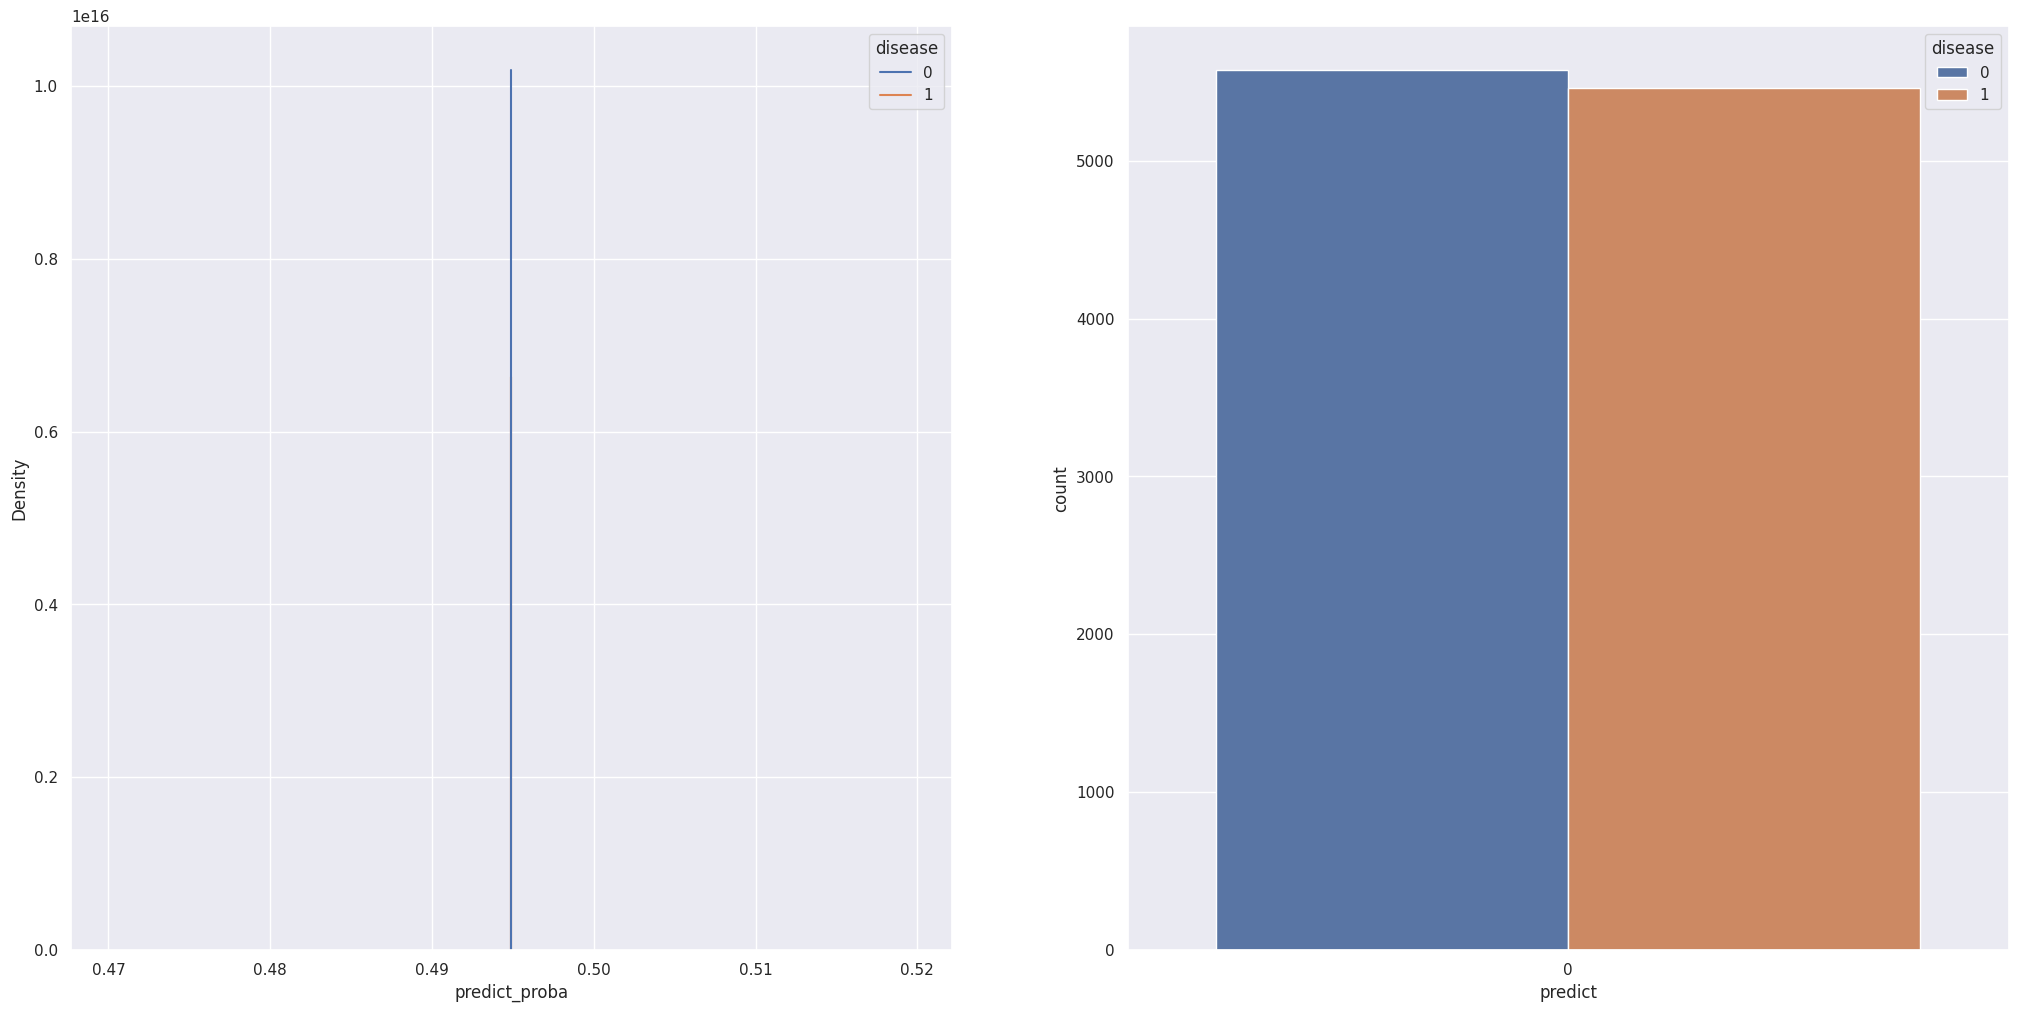

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1)

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 7.1.2 Classification Rerport

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      5575
           1       0.00      0.00      0.00      5463

    accuracy                           0.51     11038
   macro avg       0.25      0.50      0.34     11038
weighted avg       0.26      0.51      0.34     11038



### 7.1.3 Cross Validation

In [ ]:
dummy_cv = ml_cv_results("Dummy", DummyClassifier(), X_temp_cs, y_temp)
dummy_cv

,Accuracy,Precision,Recall,F1
Dummy,0.505 +/- 0.002,0.253 +/- 0.001,0.5 +/- 0.0,0.336 +/- 0.001


## 7.2 Logistic Regression

In [ ]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)
y_prob = lg.predict_proba(X_valid_cs)[:, 1]

### 7.2.1 Result

In [ ]:
lg_resul = ml_scores("Logistic Regression", y_valid, y_pred)
lg_resul

,Accuracy,Precision,Recall,F1
Logistic Regression,0.719,0.733,0.678,0.705


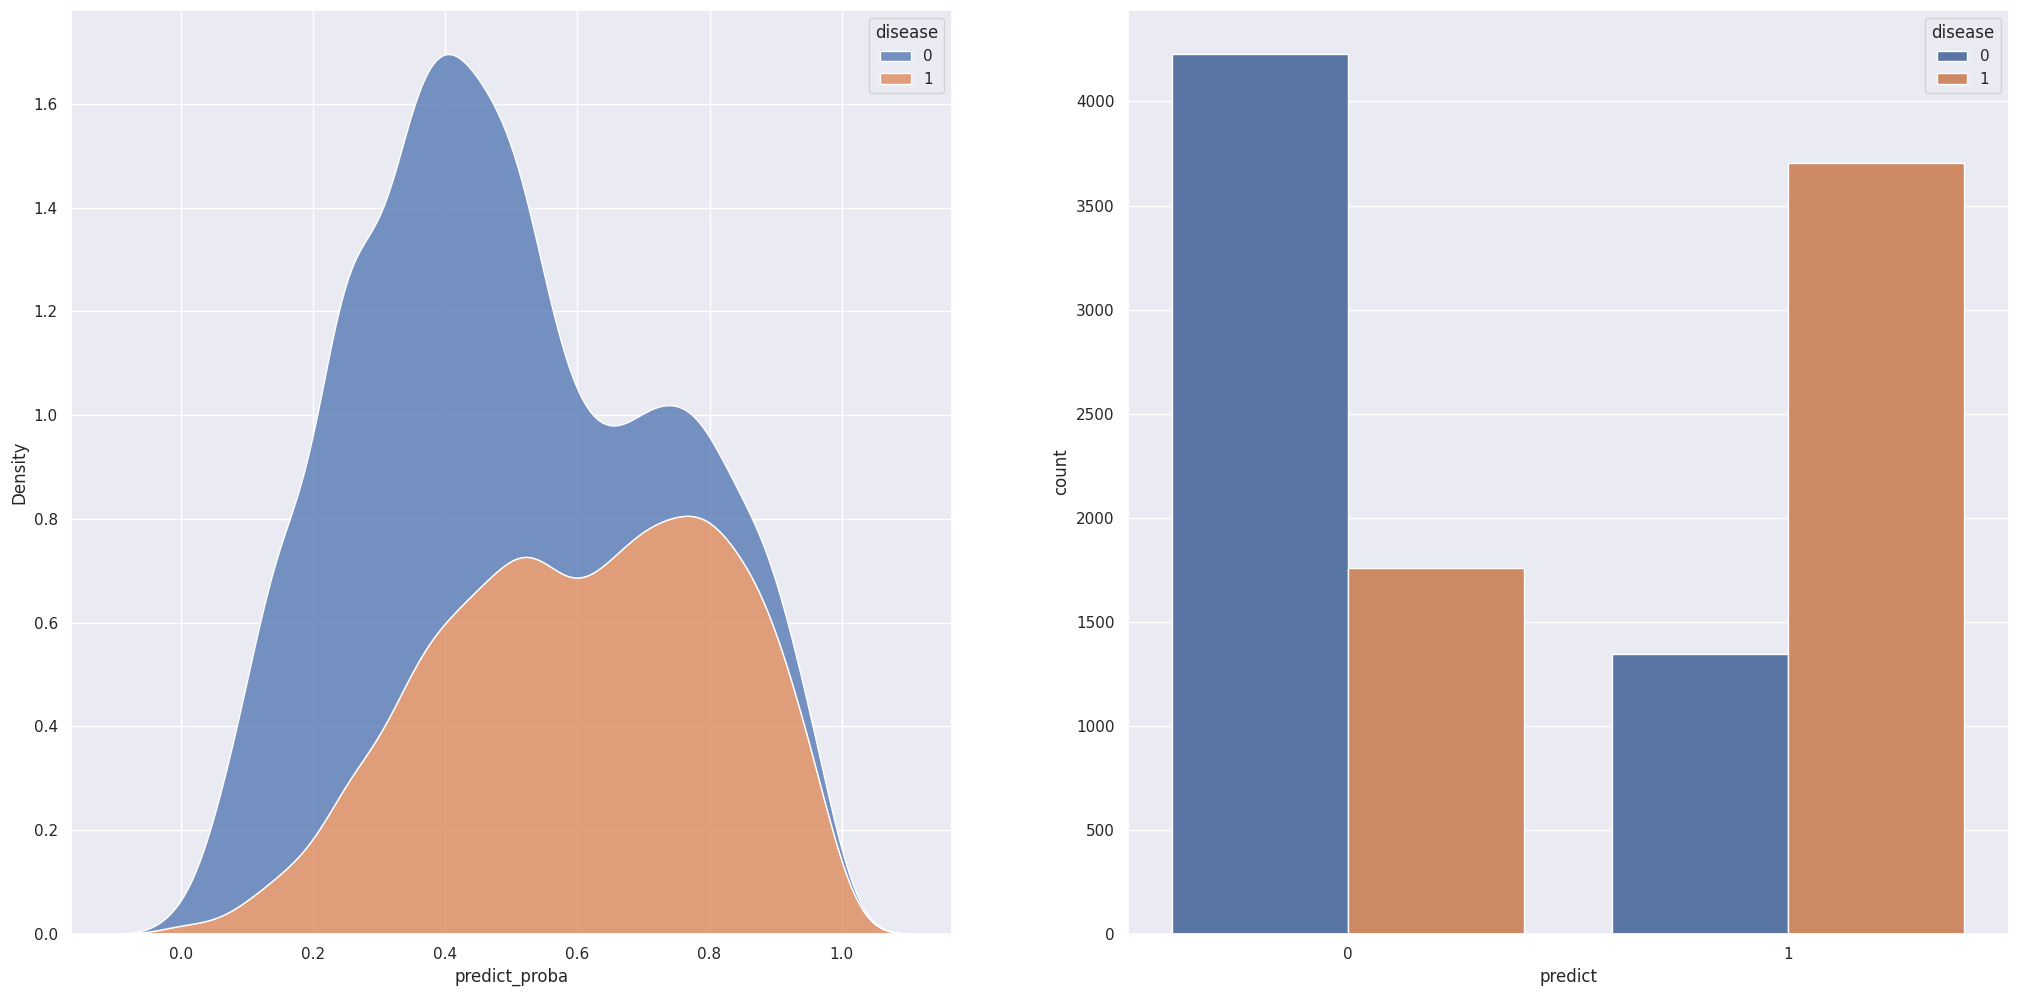

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 7.2.2 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      5575
           1       0.73      0.68      0.70      5463

    accuracy                           0.72     11038
   macro avg       0.72      0.72      0.72     11038
weighted avg       0.72      0.72      0.72     11038



### 7.2.3 Cross Validation

In [ ]:
lg_cv = ml_cv_results("Logistic Regression", LogisticRegression(), X_temp_cs, y_temp)
lg_cv

,Accuracy,Precision,Recall,F1
Logistic Regression,0.716 +/- 0.003,0.718 +/- 0.003,0.716 +/- 0.003,0.715 +/- 0.003


## 7.3 K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)
y_prob = knn.predict_proba(X_valid_cs)[:, 1]

### 7.3.1 Results

In [ ]:
knn_resul = ml_scores("KNN", y_valid, y_pred)
knn_resul

,Accuracy,Precision,Recall,F1
KNN,0.679,0.677,0.67,0.674


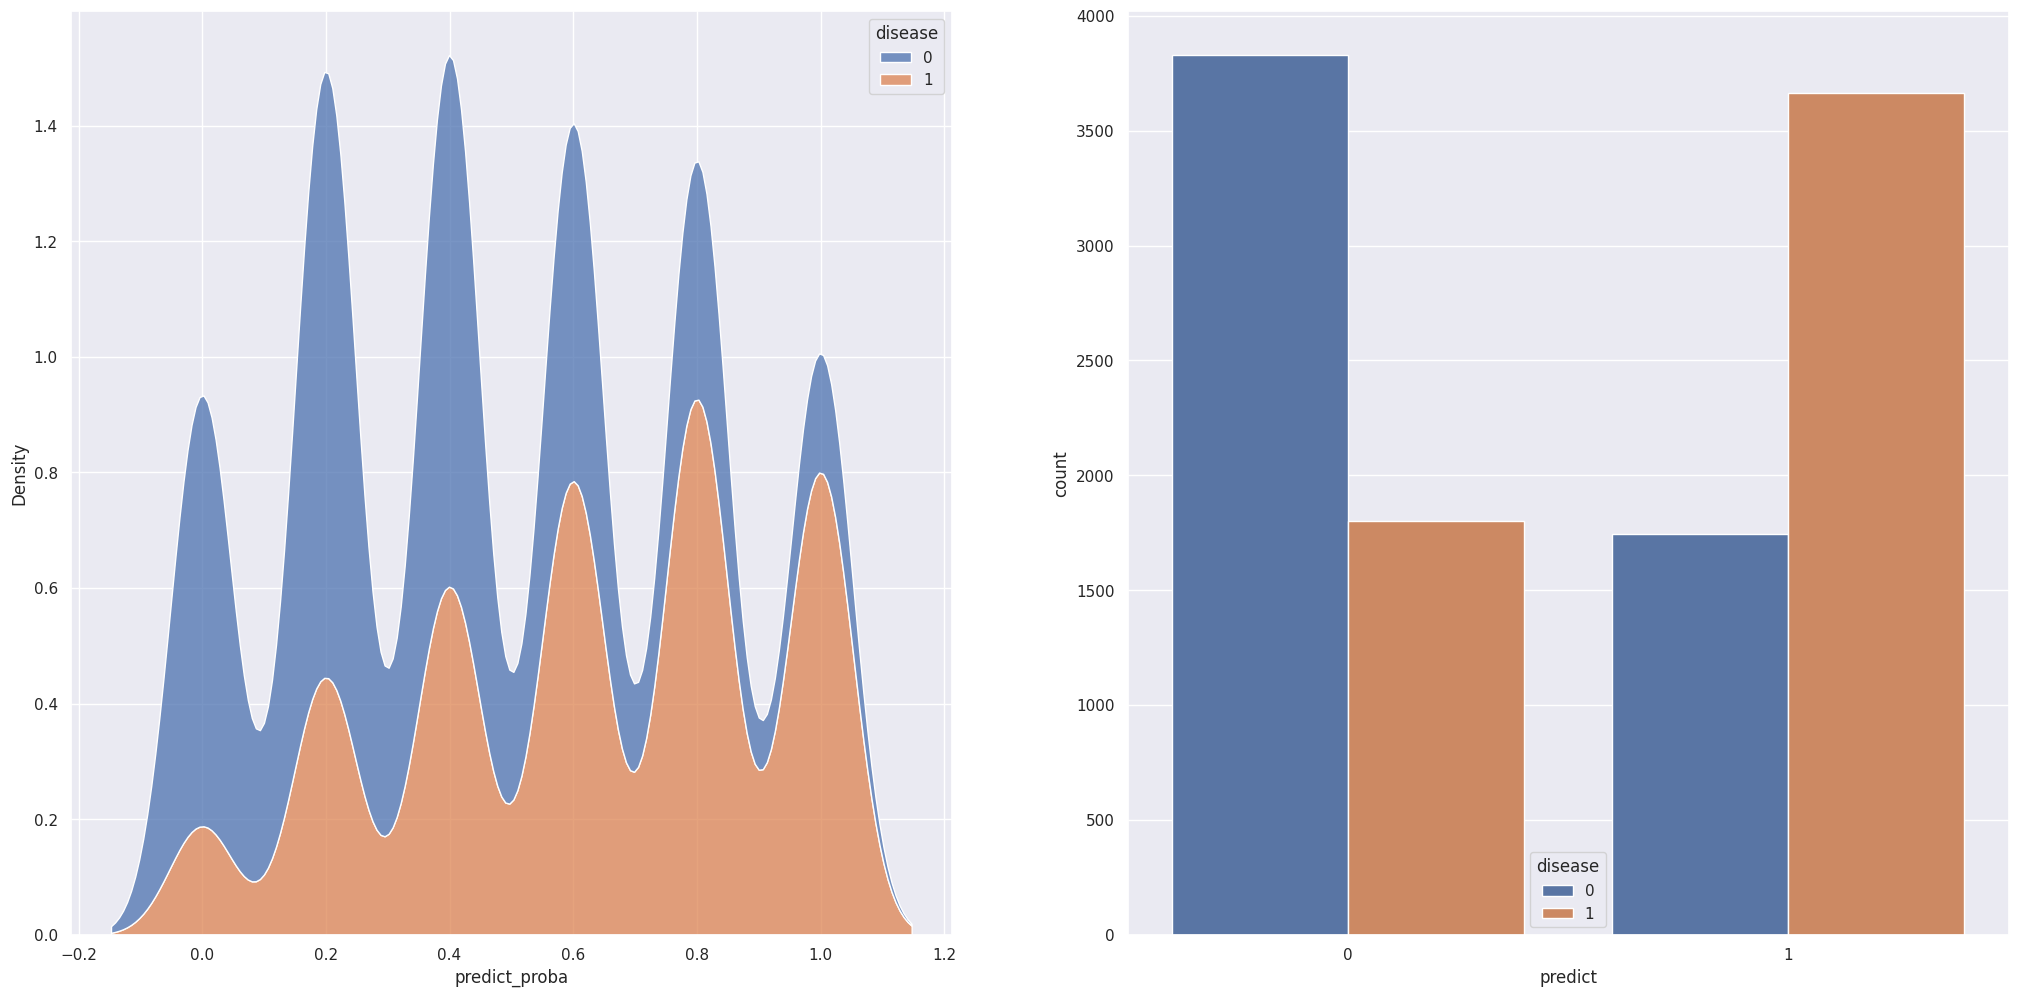

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 7.3.2 CLassification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      5575
           1       0.68      0.67      0.67      5463

    accuracy                           0.68     11038
   macro avg       0.68      0.68      0.68     11038
weighted avg       0.68      0.68      0.68     11038



### 7.3.3 Cross Validation

In [ ]:
knn_cv = ml_cv_results("KNN", KNeighborsClassifier(), X_temp, y_temp)
knn_cv

,Accuracy,Precision,Recall,F1
KNN,0.693 +/- 0.003,0.693 +/- 0.003,0.693 +/- 0.003,0.693 +/- 0.003


## 7.4 Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)
y_prob = rf.predict_proba(X_valid_cs)[:, 1]

### 7.4.1 Results

In [ ]:
rf_resul = ml_scores("Random Forest", y_valid, y_pred)
rf_resul

,Accuracy,Precision,Recall,F1
Random Forest,0.68,0.678,0.674,0.676


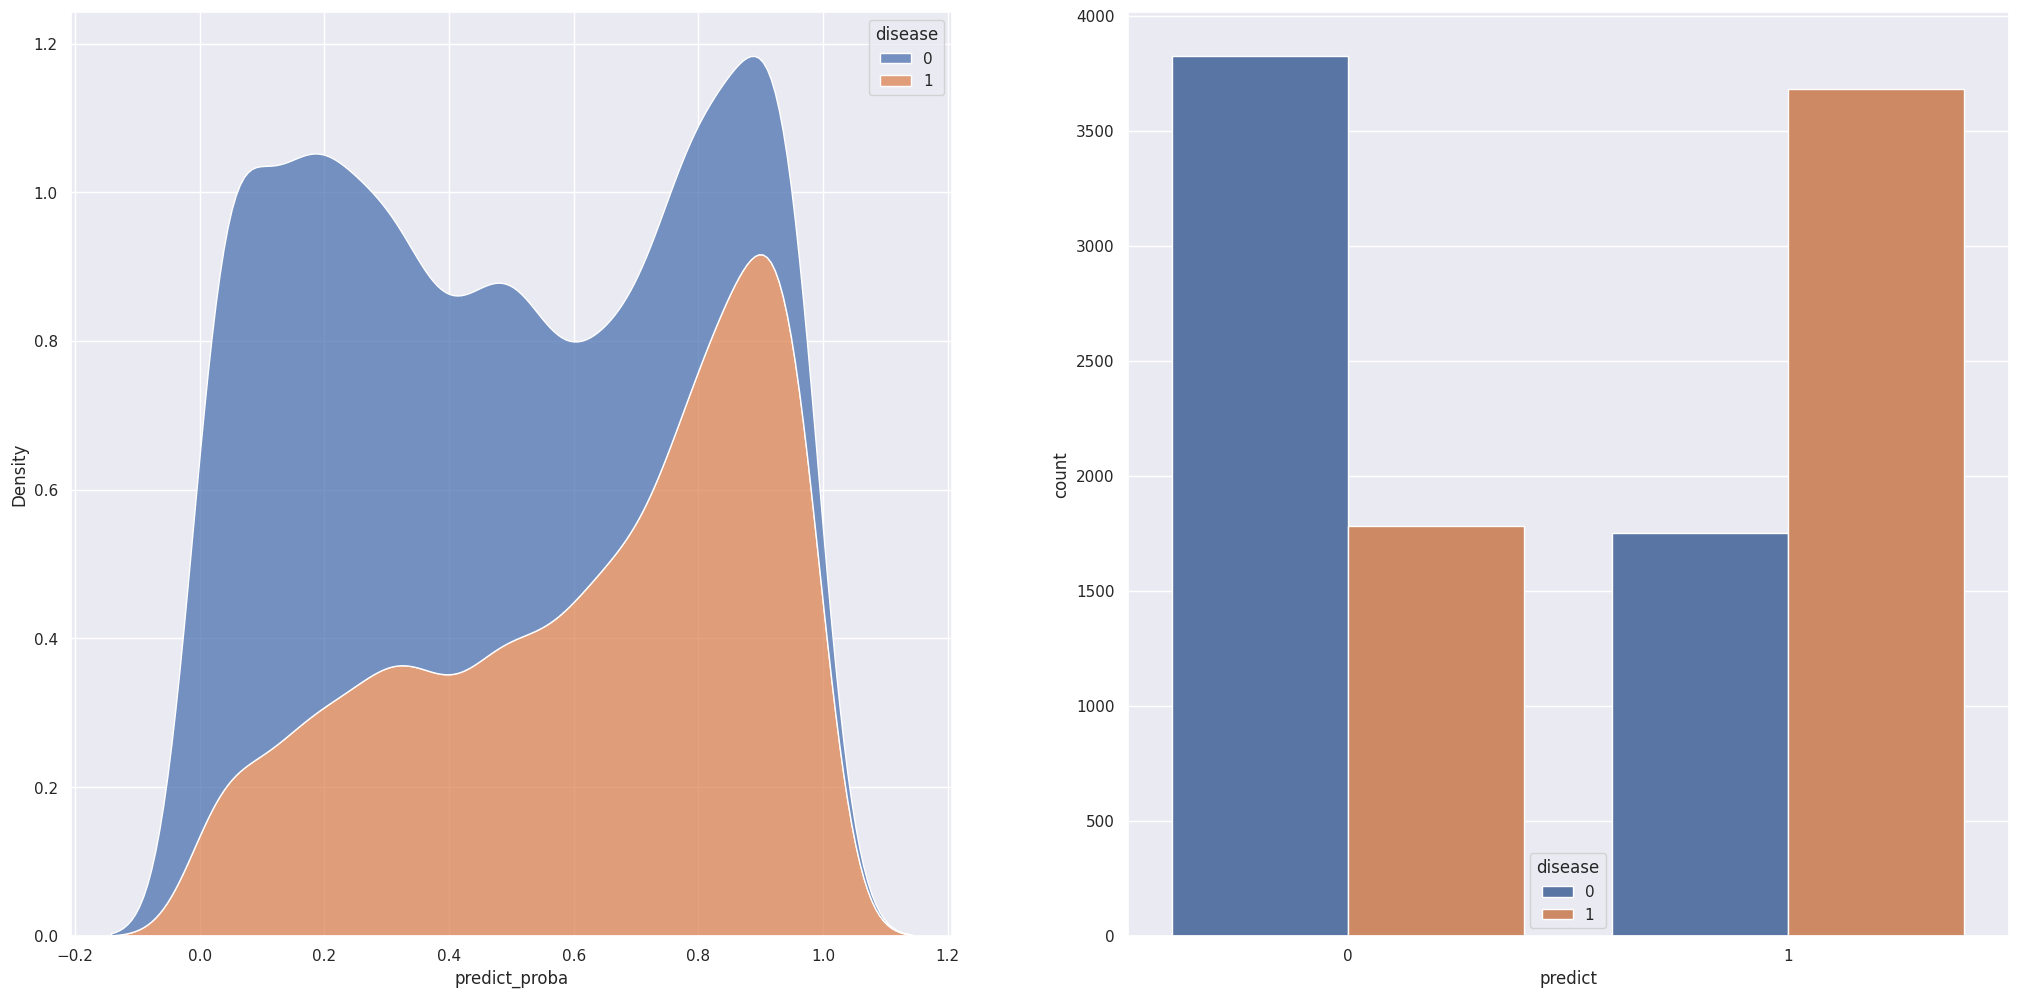

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 7.4.2 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      5575
           1       0.68      0.67      0.68      5463

    accuracy                           0.68     11038
   macro avg       0.68      0.68      0.68     11038
weighted avg       0.68      0.68      0.68     11038



### 7.4.3 Cross Validation

In [ ]:
rf_cv = ml_cv_results("Random Forest", RandomForestClassifier(), X_temp_cs, y_temp)
rf_cv

,Accuracy,Precision,Recall,F1
Random Forest,0.679 +/- 0.002,0.679 +/- 0.002,0.679 +/- 0.002,0.679 +/- 0.002


## 7.5 XGBoost Classifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)
y_prob = xgb.predict_proba(X_valid_cs)[:, 1]

### 7.5.1 Results

In [ ]:
xgb_resul = ml_scores("XGBoost", y_valid, y_pred)
xgb_resul

,Accuracy,Precision,Recall,F1
XGBoost,0.719,0.735,0.675,0.704


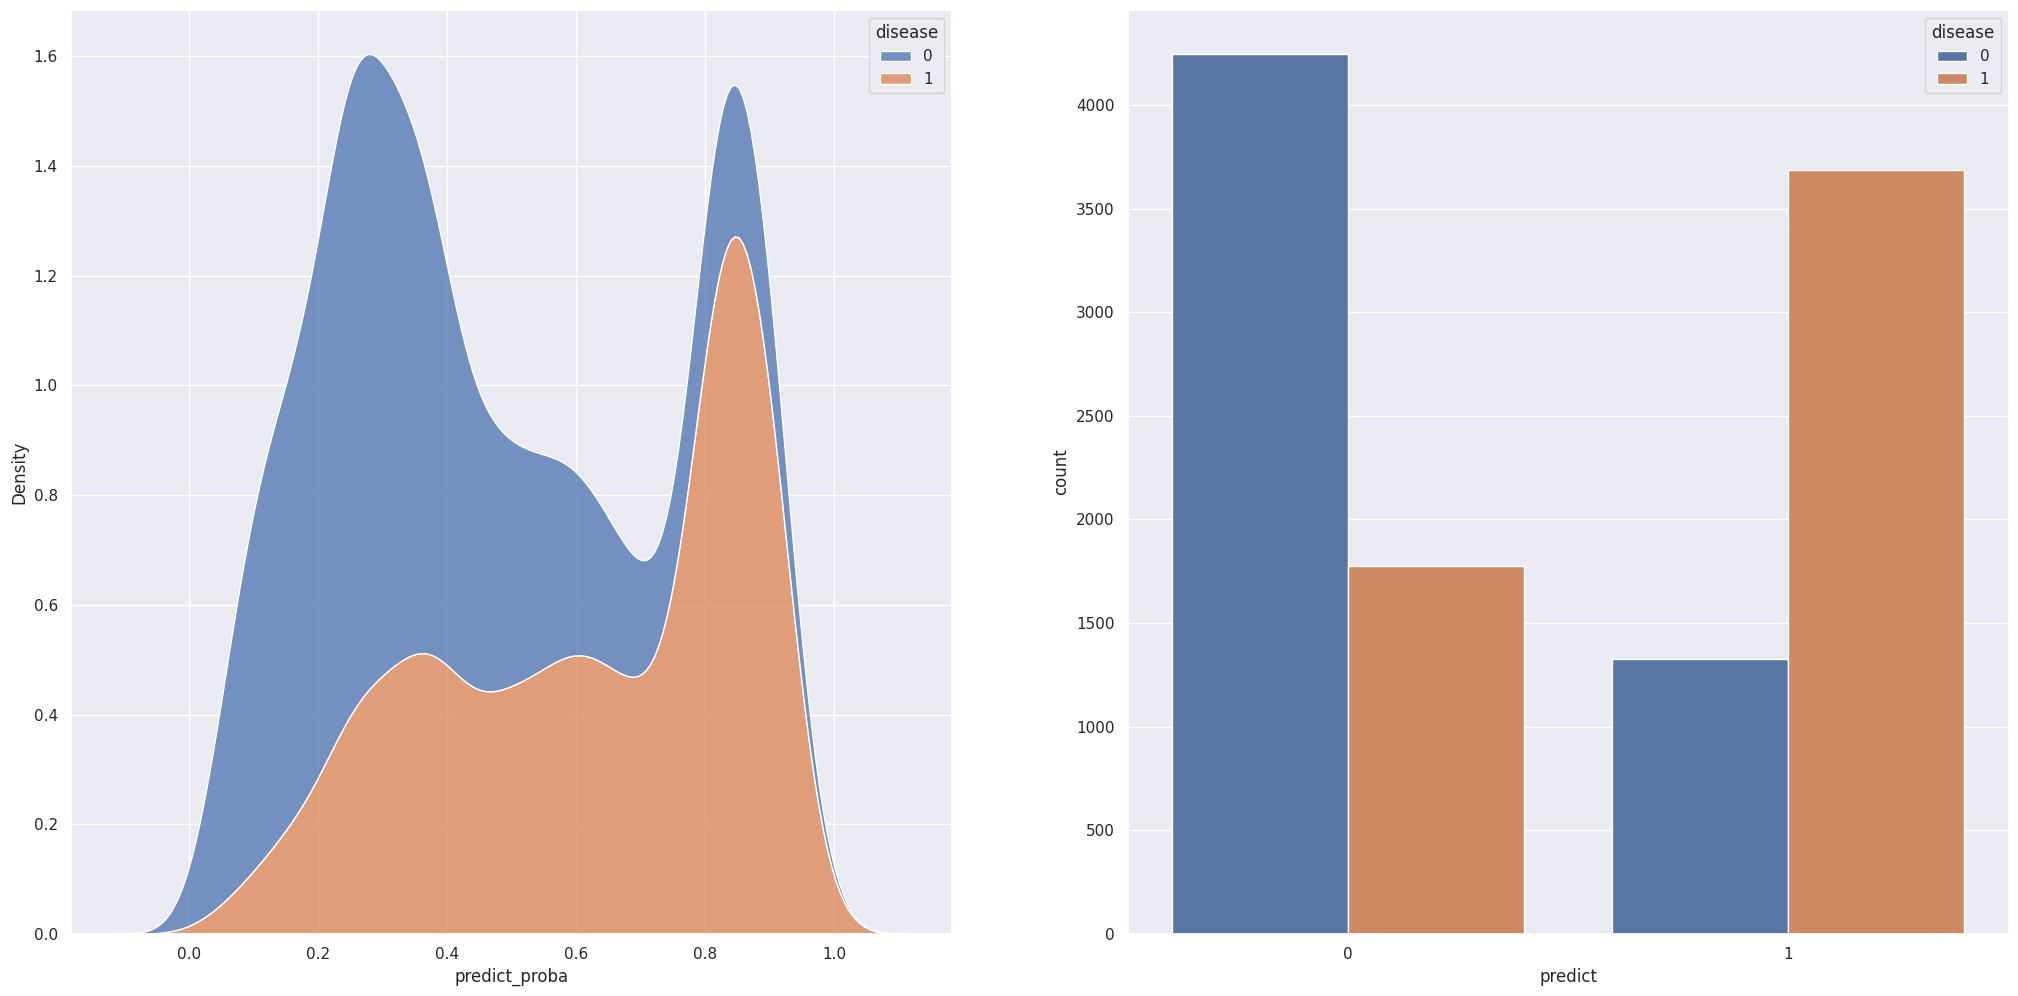

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 7.5.2 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      5575
           1       0.74      0.68      0.70      5463

    accuracy                           0.72     11038
   macro avg       0.72      0.72      0.72     11038
weighted avg       0.72      0.72      0.72     11038



### 7.5.3 Cross Validation

In [ ]:
xgb_cv = ml_cv_results("XGBoost", XGBClassifier(), X_temp_cs, y_temp)
xgb_cv

,Accuracy,Precision,Recall,F1
XGBoost,0.72 +/- 0.003,0.722 +/- 0.003,0.72 +/- 0.003,0.72 +/- 0.003


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modeling_performance = pd.concat([dummy_resul, lg_resul, knn_resul, rf_resul, xgb_resul])
modeling_performance.sort_values(by="Recall", ascending=True)

,Accuracy,Precision,Recall,F1
Dummy,0.505,0.000,0.000,0.000
Random Forest,0.681,0.683,0.664,0.673
Logistic Regression,0.716,0.736,0.665,0.699
KNN,0.681,0.681,0.669,0.675
XGBoost,0.719,0.735,0.675,0.704


### 7.6.2 Cross Validation Performance

In [ ]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, xgb_cv])
modeling_performance_cv.sort_values(by="Recall", ascending=True)

,Accuracy,Precision,Recall,F1
Dummy,0.505 +/- 0.005,0.253 +/- 0.002,0.5 +/- 0.0,0.336 +/- 0.002
Random Forest,0.681 +/- 0.006,0.681 +/- 0.006,0.681 +/- 0.006,0.681 +/- 0.006
KNN,0.693 +/- 0.005,0.694 +/- 0.004,0.693 +/- 0.004,0.693 +/- 0.004
Logistic Regression,0.718 +/- 0.004,0.72 +/- 0.004,0.718 +/- 0.004,0.717 +/- 0.004
XGBoost,0.72 +/- 0.003,0.722 +/- 0.003,0.72 +/- 0.003,0.72 +/- 0.003


I'll select Recall as a parameter for selection. Recall shows the relation between true positive and false negative. It's important for medicinal projects, which is important to reduce errors.

# 8.0 Hyperparameter Fine Tuning

## 8.1 XGBoost + Random Search

In [ ]:
# params = {
#    "learning_rate": np.arange(0.05, 1.05, 0.05),
#    "n_estimators": [200, 500, 1000, 2000],
#    "subsample": np.arange(0.05, 1.05, 0.05)
# }

# xgb = XGBClassifier()
# rscv = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=10, cv=5, verbose=10, scoring=recall)

In [ ]:
# rscv.fit(X_params_cs, y_temp)

In [ ]:
best_params = {
    'subsample': 0.7500000000000001,
    'n_estimators': 200,
    'learning_rate': 0.2
}

### 8.1.1 Result

In [ ]:
xgb_best = XGBClassifier(subsample=best_params['subsample'],
                         n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate'])

xgb_best.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_best.predict(X_valid_cs)
y_prob = xgb_best.predict_proba(X_valid_cs)[:, 1]

In [ ]:
xgb_resul = ml_scores("XGBoost", y_valid, y_pred)
xgb_resul

,Accuracy,Precision,Recall,F1
XGBoost,0.719,0.736,0.673,0.703


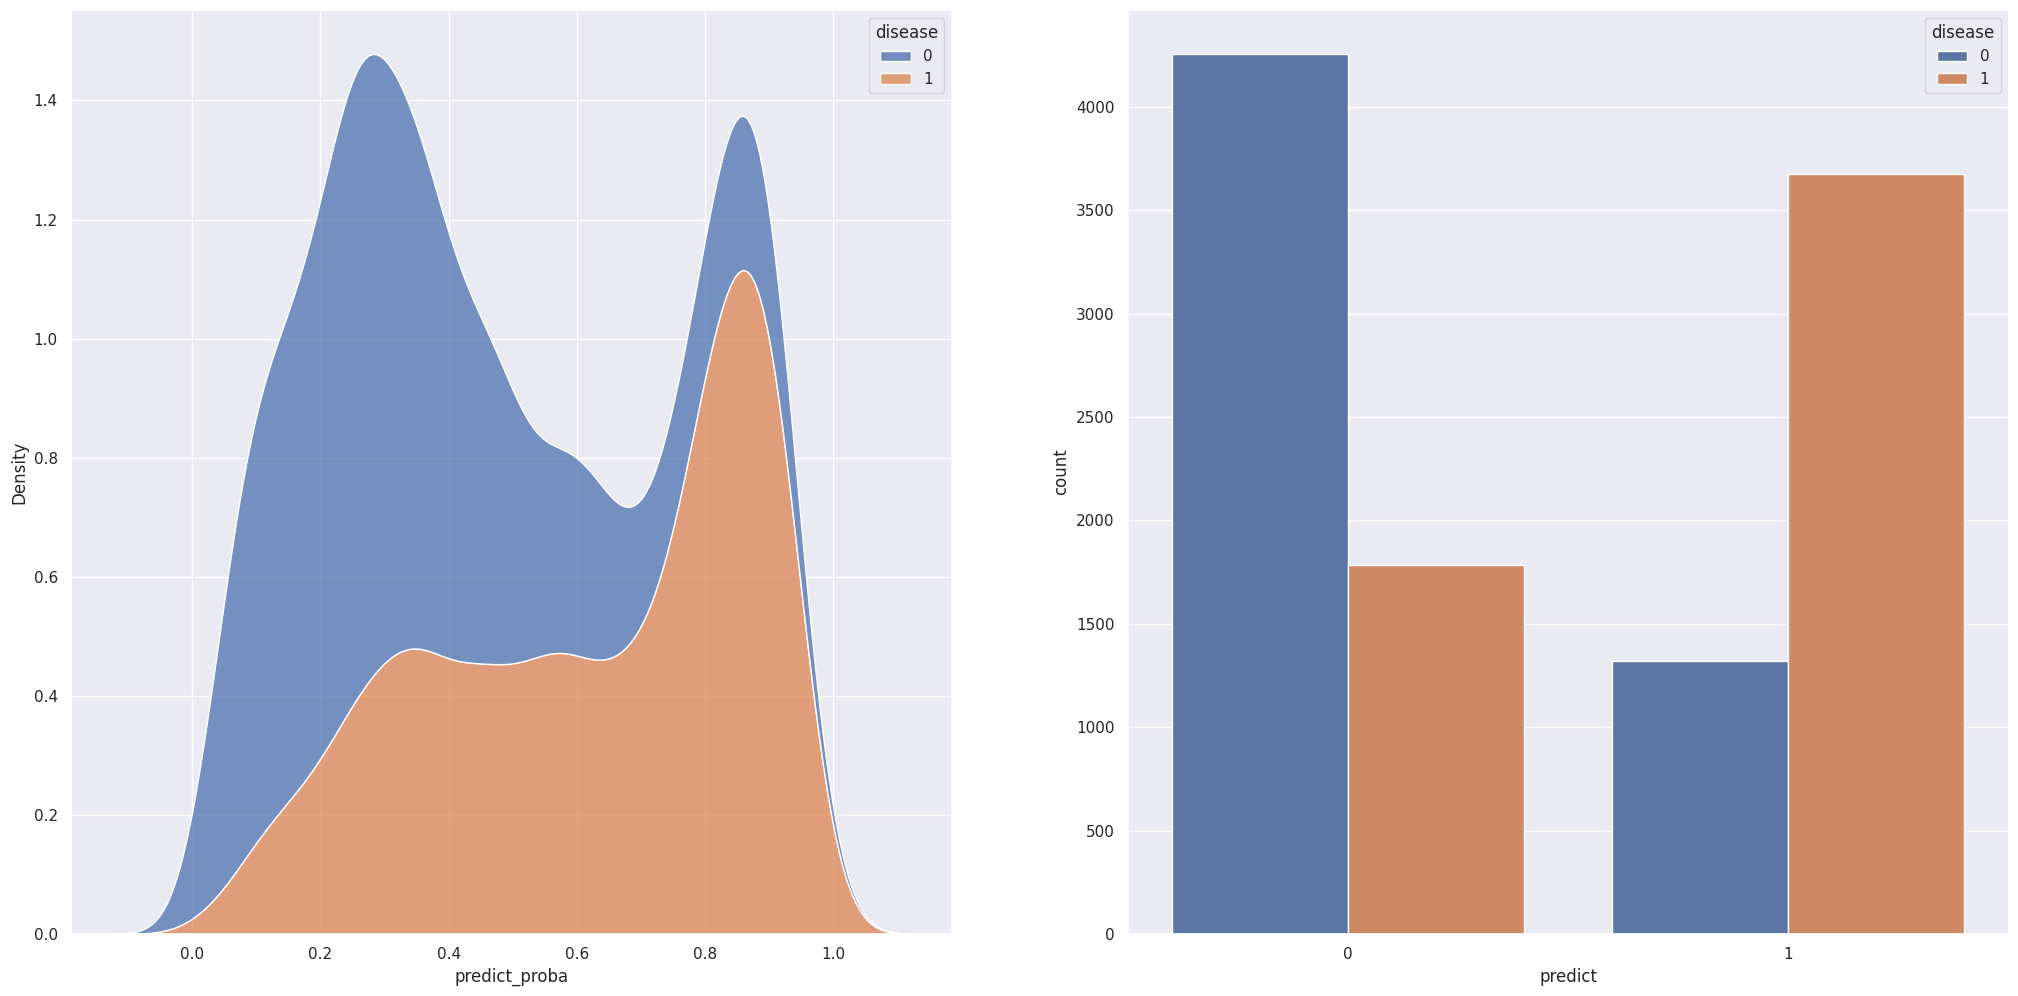

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_valid})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

### 8.2 Cross Validation

In [ ]:
xgb_best = XGBClassifier(subsample=best_params['subsample'],
                         n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate'])

In [ ]:
xgb_cv = ml_cv_results("XGBoost", xgb, X_temp_cs, y_temp)
xgb_cv

,Accuracy,Precision,Recall,F1
XGBoost,0.72 +/- 0.004,0.722 +/- 0.004,0.72 +/- 0.004,0.719 +/- 0.004


# 9.0 Conclusions

## 9.1 Final Model

In [ ]:
final_model = XGBClassifier(
    subsample=best_params['subsample'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = final_model.predict(X_test_cs)
y_prob = final_model.predict_proba(X_test_cs)[:, 1]

### 9.1.1 Unseen Data

In [ ]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Accuracy,Precision,Recall,F1
unseen,0.714,0.728,0.673,0.699


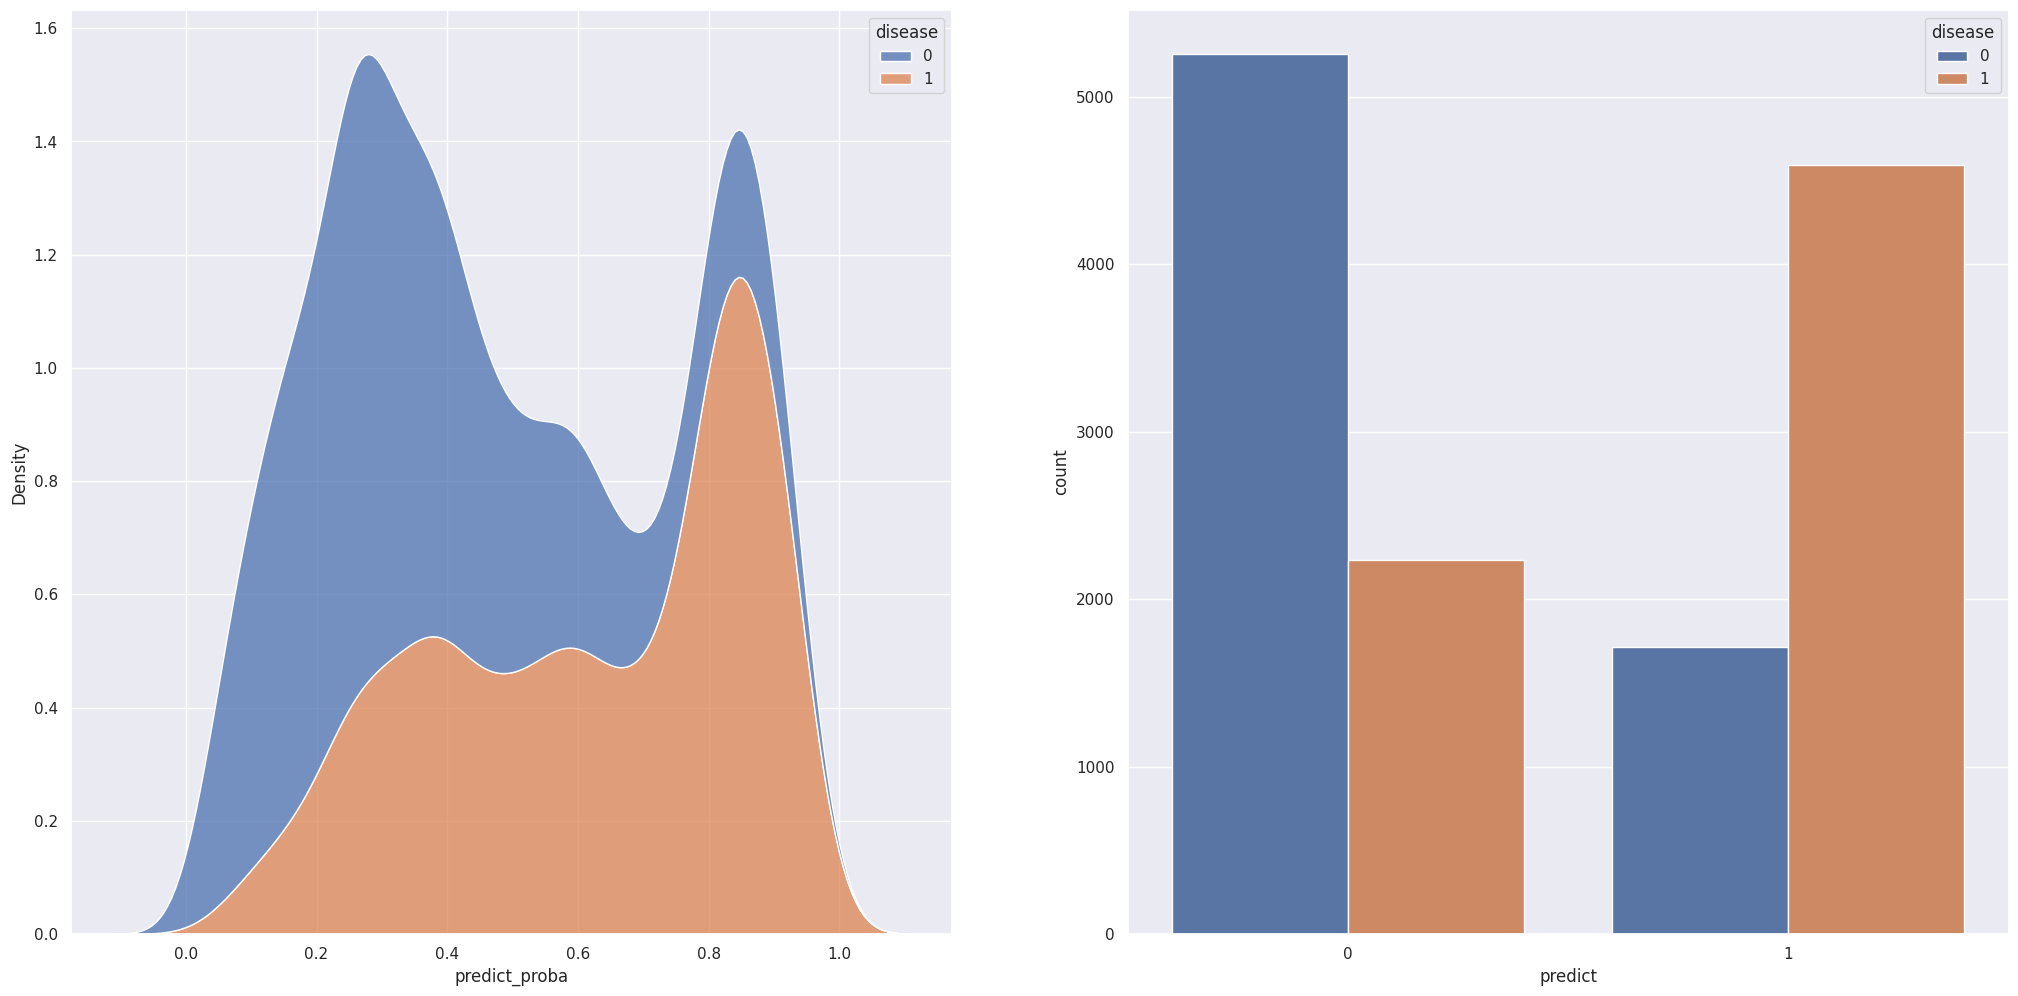

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': y_prob, 'disease': y_test})

plt.subplot(1, 2, 1)
sns.kdeplot(x='predict_proba', hue='disease', data=aux1, multiple="stack")

plt.subplot(1, 2, 2)
sns.countplot(x='predict', hue='disease', data=aux1);

## 9.2 Business Performance

### 9.2.1 What is the accuracy and precision of the model?

In [ ]:
print('''
The capacity is of the model to learn got a accuracy of {}.\n
However, using a unseen data we get a accuracy of {}.
'''.format(xgb_cv['Accuracy'][0], unseen_scores['Accuracy'][0])
     )


The capacity is of the model to learn got a accuracy of 0.72 +/- 0.004.

However, using a unseen data we get a accuracy of 0.714.



In [ ]:
print('''
The capacity is of the model to learn got a precision of {}.\n
For a generation capacity, using a unseen data, we get a precision of {}.
'''.format(xgb_cv['Precision'][0], unseen_scores['Precision'][0])
     )


The capacity is of the model to learn got a precision of 0.722 +/- 0.004.

For a generation capacity, using a unseen data, we get a precision of 0.728.



### 9.2.2 How much profit will Cardio Catch Diseases have with the new tool?

Using the unseen data as a example we can discover the profitness of the model. The company can get R$ 500.00 for each 5\% socore above 50\%, therefore I will select every customer with disease and calculate their probability to estimate the profit using the model.

In [ ]:
aux1 = pd.DataFrame({'predict': y_pred, 'predict_proba': np.round(y_prob, 2), 'disease': y_test})
aux2 = aux1[(aux1['disease'] == 1) & (aux1['predict_proba'] >= 0.55)]

In [ ]:
def calc_profit(value):
    return_value = 0

    if value >= 0.55 and value < 0.60:
        return_value += 500

    elif value >= 0.60 and value < 0.65:
        return_value += 500*2

    elif value >= 0.65 and value < 0.70:
        return_value += 500*3

    elif value >= 0.70 and value < 0.75:
        return_value += 500*4

    elif value >= 0.75 and value < 0.80:
        return_value += 500*5

    elif value >= 0.80 and value < 0.85:
        return_value += 500*6

    elif value >= 0.85 and value < 0.90:
        return_value += 500*7

    elif value >= 0.90 and value < 0.95:
        return_value += 500*8

    else:
        return_value += 500*9

    return return_value

In [ ]:
aux2['value_return'] = aux2['predict_proba'].apply(calc_profit)
aux2['value_return'].sum()

np.int64(11342000)

In [ ]:
print('The profit using the model is R$ 11,285,500.00.')

The profit using the model is R$ 11,285,500.00.


### 9.2.3 How reliable is the result given by the new tool?

In [ ]:
print('''
The capacity of the model to recognize {} of the customers with disease.\n
For a generation capacity, using a unseen data, the model could recognize {}%.
'''.format(xgb_cv['Recall'][0], unseen_scores['Recall'][0])
     )


The capacity of the model to recognize 0.72 +/- 0.004 of the customers with disease.

For a generation capacity, using a unseen data, the model could recognize 0.673%.

